# Lista 5 Parte 2
- MAE5871 - Análise espectral de séries temporais

- Renan de Luca Avila

- 25/11/2019

- Todo o Código produzido aqui pode ser encontrado em: https://github.com/avilarenan/AnaliseEspectralDeSeriesTemporais

## Imports

In [137]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from scipy import signal
import random
import pywt
import pywt.data
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import random
from PyEMD import EMD, CEEMDAN
import pandas as pd
import numpy as np
from pyfiglet import Figlet
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
f = Figlet(font='slant')
import scaleogram as scg

## Funções auxiliares

In [187]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

##### All code is available at: https://github.com/avilarenan/AnaliseEspectralDeSeriesTemporais

YLIM_DEFAULT_OFFSET = 10

def clear_plots():
    plt.clf()
    plt.close()
    
def simple_plot(data, title, figsize=(20, 4), fontsize=20):
    clear_plots()
    fig = plt.figure(figsize=figsize)
    plt.plot(data)
    fig.suptitle(title, fontsize=20)
    plt.show()
    
def rebuild_signal(ca, cd, w, title):
    rebuilt_signal = pywt.idwt(ca, cd, w, 'smooth') # inverse dwt transform for recomposing the signal 
    simple_plot(rebuilt_signal, title)

def plot_family_of_wavelets(plot_data=[('db', (4, 3)), ('sym', (4, 3)), ('coif', (3, 2))], second_plot_data=[]):
    clear_plots()
    for family, (rows, cols) in plot_data:
        fig = plt.figure(figsize=(20, 12))
        fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)
        colors = itertools.cycle('bgrcmyk')

        wnames = pywt.wavelist(family)
        i = iter(wnames)
        for col in range(cols):
            for row in range(rows):
                try:
                    wavelet = pywt.Wavelet(next(i))
                except StopIteration:
                    break
                phi, psi, x = wavelet.wavefun(level=5)

                color = next(colors)
                ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
                ax.set_title(wavelet.name + " phi")
                ax.plot(x, phi, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
                ax.set_title(wavelet.name + " psi")
                ax.plot(x, psi, color)
                ax.set_xlim(min(x), max(x))

    for family, (rows, cols) in second_plot_data:
        fig = plt.figure(figsize=(20, 12))
        fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)

        colors = itertools.cycle('bgrcmyk')
        wnames = pywt.wavelist(family)
        i = iter(wnames)
        for col in range(cols):
            for row in range(rows):
                try:
                    wavelet = pywt.Wavelet(next(i))
                except StopIteration:
                    break
                phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
                row *= 2

                color = next(colors)
                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
                ax.set_title(wavelet.name + " phi")
                ax.plot(x, phi, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
                ax.set_title(wavelet.name + " psi")
                ax.plot(x, psi, color)
                ax.set_xlim(min(x), max(x))

                row += 1
                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
                ax.set_title(wavelet.name + " phi_r")
                ax.plot(x, phi_r, color)
                ax.set_xlim(min(x), max(x))

                ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
                ax.set_title(wavelet.name + " psi_r")
                ax.plot(x, psi_r, color)
                ax.set_xlim(min(x), max(x))

    plt.show()
    
def plot_signal_decomp(data, w, title):
    clear_plots()
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure(figsize=(20, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.94)
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Approximation Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Detail Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        
    plt.show()

def line_break():
    print(f.renderText('-------------'))
    
def lil_break():
    print(f.renderText('*********'))
    
def plot_ceemdan_decomp(data, title, use_ceemdan=True, orig_data=None, noise_component_qty=1):
    # expected to receive single dimensional np array
    s = data

    emd_config = {"std_thr": 0.001, "range_thr": 0.005}
    emd = EMD(spline_kind='cubic', nbsym=10, **emd_config)

    ceemdan_config = {"range_thr": 0.0001, "total_power_thr": 0.001}
    ceemdan = CEEMDAN(trials=500, epsilon=2, ext_EMD=emd, parallel=True, **ceemdan_config)

    if use_ceemdan == True:
        IMFs = ceemdan(s)
    else:
        emd = EMD()
        IMFs = emd(s)
    
    name = 'CEEMDAN' if use_ceemdan == True else 'EMD'
    clear_plots()
    mse_recomp = plot_ceemdan_apart(data, IMFs, title, noise_component_qty, orig_data)
    
    lil_break()
            
    return IMFs
    
def plot_ceemdan_apart(data, IMFs, title='', noise_component_qty=1, orig_data=None):
    clear_plots()
    rows = 8
    cols = 2
    fig = plt.figure(figsize=(24, 12))
    fig.subplots_adjust(hspace=0.6, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.96)
    colors = itertools.cycle('bgrcmyk')

    j = 1
    ax_main = fig.add_subplot(rows, 1, j)
    ax_main.set_title(title)
    ax_main.plot(data)
    
    j += 1
    for k in range(cols*rows):
        if j < len(IMFs)+2:
            j += 1
            color = next(colors)
            ax = fig.add_subplot(rows, cols, j)
            ax.set_title(title + f' component {j-2}')
            ax.plot(IMFs[j-3], color)
    
    recomp = recompose_ceemdan_without_noise(IMFs,noise_component_qty)
    
    ax = fig.add_subplot(rows, 1, rows-1)
    ax.set_title(title + f'Denoised Recomposed qty = {noise_component_qty}')
    ax.plot(recomp, color)
        
    plt.show()
    mse_recomp = 0
    if orig_data is not None:
        mse_recomp = mse_numpy(recomp, orig_data)
    print(f'Recomposição {name} recomp/data | MSE = {mse_numpy(recomp, data)}')
    
    print(f'noise added data/orig_data mse = {mse_numpy(data, orig_data)}')
    
    print(f'Recomposição {name} recomp/orig_data | MSE = {mse_recomp}')
    
    print(f'Melhora: {((mse_numpy(data, orig_data)/mse_recomp)-1)*100}%')
    
    return mse_recomp
    
def mse_numpy(data_1, data_2):
    return np.square(np.subtract(data_1,data_2)).mean() 
            
def recompose_ceemdan_without_noise(IMFs, noise_component_qty=1):
    IMFsX = IMFs[noise_component_qty:]
    return IMFsX.sum(axis=0)
    
def plot_coeffs(data, w, title, level, use_dwt=True):
    clear_plots()
    """Show dwt or swt coefficients for given data and wavelet."""
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []

    if use_dwt:
        for i in range(5):
            (a, d) = pywt.dwt(a, w, mode)
            if len(a) > 1:
                ca.append(a)
                cd.append(d)
    else:
        coeffs = pywt.swt(data, w, level)  # [(cAn, cDn), ..., (cA1, cD1)]
        for a, d in reversed(coeffs):
            ca.append(a)
            cd.append(d)

    fig = plt.figure(figsize=(20, 12))
    ax_main = fig.add_subplot(len(ca) + 1, 1, 1)
    ax_main.set_title(title, fontsize=14)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, x in enumerate(ca):
        ax = fig.add_subplot(len(ca) + 1, 2, 3 + i * 2)
        ax.plot(x, 'r', marker="o", linestyle='None')
        if i == 0:
            ax.set_title("Approximation coefficients", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        if use_dwt:
            ax.set_xlim(0, len(x) - 1)
        else:
            ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

    for i, x in enumerate(cd):
        ax = fig.add_subplot(len(cd) + 1, 2, 4 + i * 2)
        ax.plot(x, 'g', marker="o", linestyle='None')
        if i == 0:
            ax.set_title("Detail coefficients", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
        # Scale axes
        ax.set_xlim(0, len(x) - 1)
        if use_dwt:
            ax.set_ylim(min(0, 1.4 * min(x)), max(0, 1.4 * max(x)))
        else:
            vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
            ax.set_ylim(min(0, 2 * min(vals) if len(vals) > 0 else -YLIM_DEFAULT_OFFSET), max(0, 2 * max(vals)) if len(vals) > 0 else YLIM_DEFAULT_OFFSET)
    
def plot_mult_wavelet_decomp(data, wavelet_set=['haar','db8'], title='', orig_data=None, noise_component_qty=1):
    for wav_name in wavelet_set:
        plot_wavelet_decomp(data, wav_name, f'{title} - {wav_name}', orig_data, noise_component_qty)
        wavelet_denoise(data, wav_name, orig_data)
        lil_break()
        
def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])
    min_length = min(lens)
    if min_length > signal_length:
        min_length = signal_length
    
    new_data = []
    for i in data:
        new_data += [i[:min_length]]

    out = np.asarray(new_data)
    return out
    
def plot_wavelet_decomp(data, w, title, orig_data=None, noise_component_qty=1):
    clear_plots()
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure(figsize=(20, 12))
    fig.subplots_adjust(hspace=0.6, wspace=0.2, bottom=.02, left=.06,
                            right=.97, top=.92)
    ax_main = fig.add_subplot(len(rec_a) + 2, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 2, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Approximation Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 2, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        if i == 0:
            ax.set_title("Detail Components", fontsize=14)
        ax.set_ylabel("Level %d" % (i + 1))
    
    rec_a = np.asarray(rec_a)
    rec_d = np.asarray(rec_d)
    
    rec_d = rec_d[noise_component_qty:]
    if remove_detail_and_approx_noise_components:
        rec_a = rec_a[noise_component_qty:]
    
    all_rec = np.append(rec_a, rec_d, axis=0)
    
    all_rec = numpy_fillna(all_rec)
    
    all_rec = all_rec.sum(axis=0)
    
    ax = fig.add_subplot(len(rec_a) + 2, 1, len(rec_a) + 2)
    ax.set_title("Denoised Recomposition DWT", fontsize=14)
    ax.plot(all_rec, 'b')
    
    plt.show()
    
def wavelet_denoise(data, wav_name, orig_data=None):

    # Create wavelet object and define parameters
    w = pywt.Wavelet(wav_name)
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    # maxlev = 2 # Override if desired
    print("maximum level is " + str(maxlev))

    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, wav_name, level=maxlev)

    #cA = pywt.threshold(cA, threshold*max(cA))
    plt.figure(figsize=(20, 12))
    for i in range(1, len(coeffs)):
        plt.subplot(maxlev, 1, i)
        plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        plt.plot(coeffs[i])

    datarec = pywt.waverec(coeffs, wav_name)

    index = range(0,len(data))
    mintime = 0
    maxtime = len(index)

    plt.figure(figsize=(20,12))
    plt.subplot(3, 1, 1)
    plt.plot(index[mintime:maxtime], data[mintime:maxtime])
    if orig_data is None:
        plt.title("Original signal")
    else:
        plt.title("Noise Added signal")
    plt.subplot(3, 1, 2)
    plt.plot(index[mintime:maxtime], datarec[mintime:maxtime])
    plt.title("De-noised signal using wavelet thresholding")
    plt.subplot(3, 1, 3)
    if orig_data is None:
        plt.title(f'The following graph will be blank because we are not comparing denoising on noise added signal')
    else:
        plt.title(f'The following graph compares denoising on noise added signal')
        plt.plot(index[mintime:maxtime], orig_data[mintime:maxtime])
        plt.title("Original signal")

    plt.tight_layout()
    plt.show()
    if orig_data is not None:
        print(f'noise added data/orig_data mse = {mse_numpy(data, orig_data)}')
        print(f'mse recomp/orig_data = {mse_numpy(datarec, orig_data)}')
        print(f'mse recomp/data = {mse_numpy(datarec, data)}')
        print(f'Melhora: {((mse_numpy(data, orig_data)/mse_numpy(datarec, orig_data))-1)*100}%')

def plot_scaleogram(signal, title='Signal to be Scaleogramed', figsize=(20,12)):
    # let consider a timeline with 1 sample / second
    ns   = len(signal)
    time = np.arange(ns)

    # and a range of scales to perform the transform
    scales = scg.periods2scales( np.arange(1, 40) )

    # and a periodic signal with varying amplitude
    periodic1 = signal

    # plot the signal 
    fig1, ax1 = plt.subplots(1, 1, figsize=figsize);  
    lines = ax1.plot(periodic1); 
    ax1.set_xlim(0, len(time))
    ax1.set_title(title)
    fig1.tight_layout()

    # and the scaleogram
    ax2 = scg.cws(periodic1, scales=scales, figsize=figsize); 
    plt.tight_layout()

    print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
          pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

## Dados

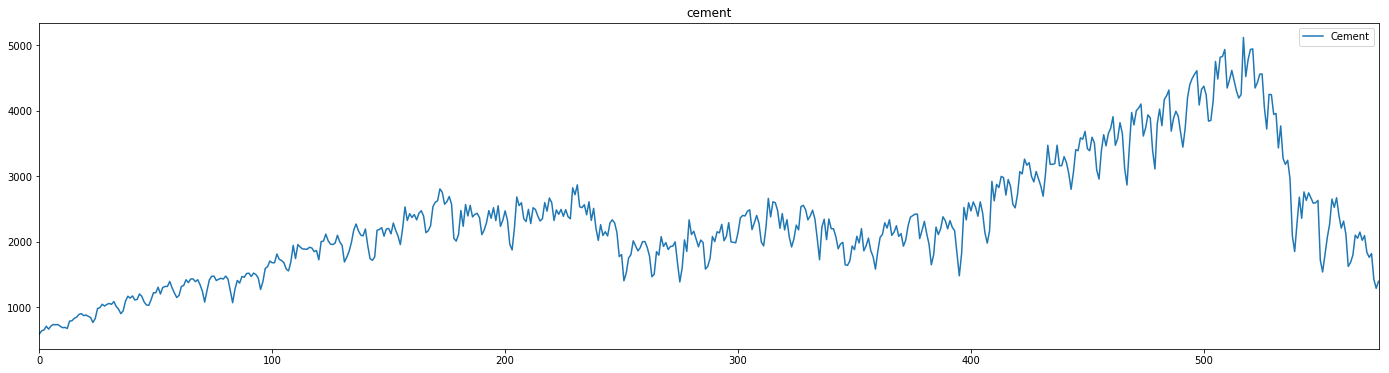

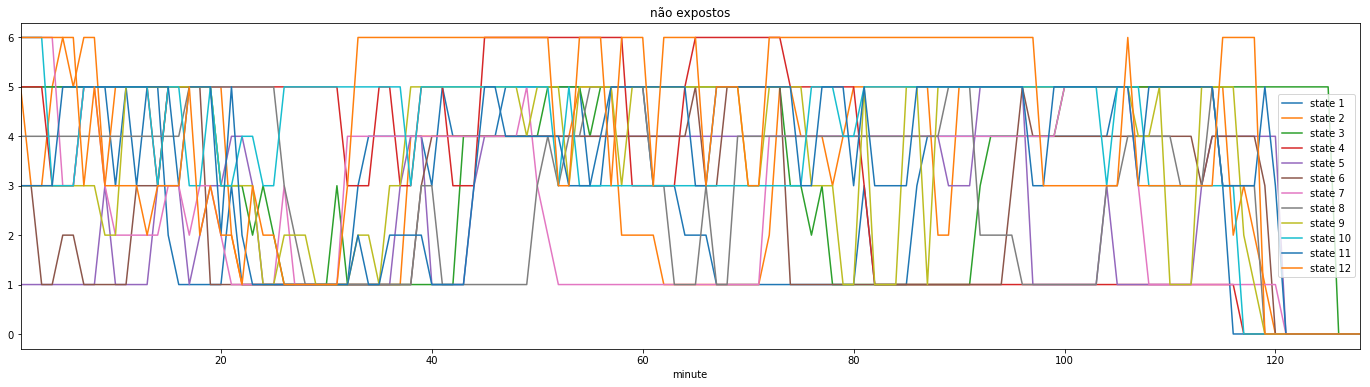

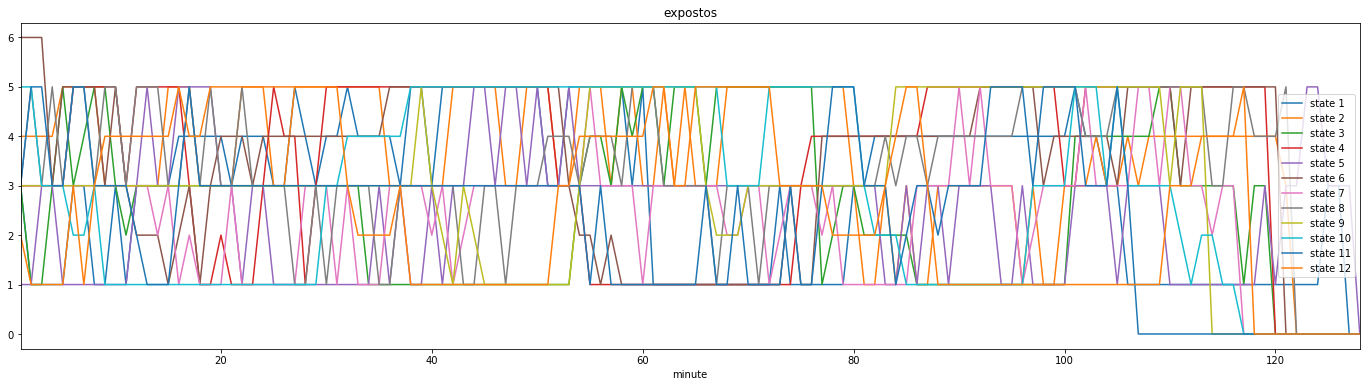

In [177]:
getcement().plot(figsize=(24,6), title='cement')
getgrp1().plot(figsize=(24,6), title='não expostos')
getgrp2().plot(figsize=(24,6), title='expostos')

In [174]:
def getcement():
    cement_data = pd.read_excel('data/Cement Datastream_1964_2012a.xls')
    cement_data.columns = ['Cement']
    return cement_data
    
def getgrp1():
    with open(f'data/grp1-dado stoffer.txt') as f:
        several_series = []
        prev_lines = []
        i = 0
        for line in f:
            i += 1
            p_line = line.strip('\n')
            p_line = [int(s) for s in p_line.split() if s.isdigit()]


            if len(p_line) == 3 and p_line[1] == 128:
                prev_lines += [p_line]
                several_series += [prev_lines]
                prev_lines = []

            if len(p_line) == 3 and i > 9 and (i-9) % 128 != 0:
                prev_lines += [p_line]

        df_full = []
        i = 0
        for series in several_series:
            df = pd.DataFrame(series, columns=['infant id','minute','state']).set_index('minute')
            infant_id = df['infant id'].iloc[0]
            df = df.drop('infant id', 1)
            renamed = f'state {infant_id}'
            df = df.rename(columns={'state':renamed})
            if i == 0:
                df_full = df
            else:
                df_full = df_full.join(df)
            i += 1

        return df_full
    
def getgrp2():
    with open(f'data/grp2-dado stoffer.txt') as f:
        several_series = []
        prev_lines = []
        i = 0
        for line in f:
            i += 1
            p_line = line.strip('\n')
            p_line = [int(s) for s in p_line.split() if s.isdigit()]


            if len(p_line) == 3 and p_line[1] == 128:
                prev_lines += [p_line]
                several_series += [prev_lines]
                prev_lines = []

            if len(p_line) == 3 and (i) % 128 != 0:
                prev_lines += [p_line]

        df_full = []
        i = 0
        for series in several_series:
            df = pd.DataFrame(series, columns=['infant id','minute','state']).set_index('minute')
            infant_id = df['infant id'].iloc[0]
            df = df.drop('infant id', 1)
            renamed = f'state {infant_id}'
            df = df.rename(columns={'state':renamed})
            if i == 0:
                df_full = df
            else:
                df_full = df_full.join(df)
            i += 1

        return df_full
    
def concatgrps():
    filenames = ['data/grp1-dado stoffer.txt', 'data/grp2-dado stoffer.txt']
    with open('data/grp-dado stoffer.txt', 'w') as outfile:
        for fname in filenames:
            with open(fname) as infile:
                outfile.write(infile.read())

## Base and control Variables

In [135]:
artificial_signals = [
    'Blocks',
    'Bumps',
    'HeaviSine',
    'Doppler',
    'Ramp',
    'HiSine',
    'LoSine',
    'LinChirp',
    'TwoChirp',
    'QuadChirp',
    'MishMash',
    'WernerSorrows',
    'HypChirps',
    'LinChirps',
    'Chirps',
    'Piece-Regular',
    'Piece-Polynomial',
    'Riemann']

# Bumps
# Heavisine
# WernerSorrows
# chirps
# losine

wavelet_set = ['haar', 'db8', 'sym16']
wavelet_set = ['db8']
mode = pywt.Modes.smooth
artificial_signals = ['Doppler']
signal_length = 1024
# signal_length = 171
plot_ceemdan = True
plot_wavelets = True 
use_ceemdan = True

index = range(signal_length)
threshold = 100 # Threshold for filtering
wav_name = 'db8'


std_noise = 0.1375
avg_noise = 0
noise = np.random.normal(avg_noise,std_noise,signal_length) # média = 0, variância = 0.25 => ruído branco

add_noise = True

noise_component_qty = 1
remove_detail_and_approx_noise_components = True

# choose default wavelet function for the entire notebook
scg.set_default_wavelet('cmor1-1.5')

# Try these ones to see various compromises between scales and time resolution 
#scg.set_default_wavelet('cgau5')
#scg.set_default_wavelet('cgau1')
#scg.set_default_wavelet('shan0.5-2')
#scg.set_default_wavelet('mexh')

NameError: name 'scg' is not defined

## Exercício 7
- Lista 5
- Professora: Chang
- Aluno: Renan de Luca Avila

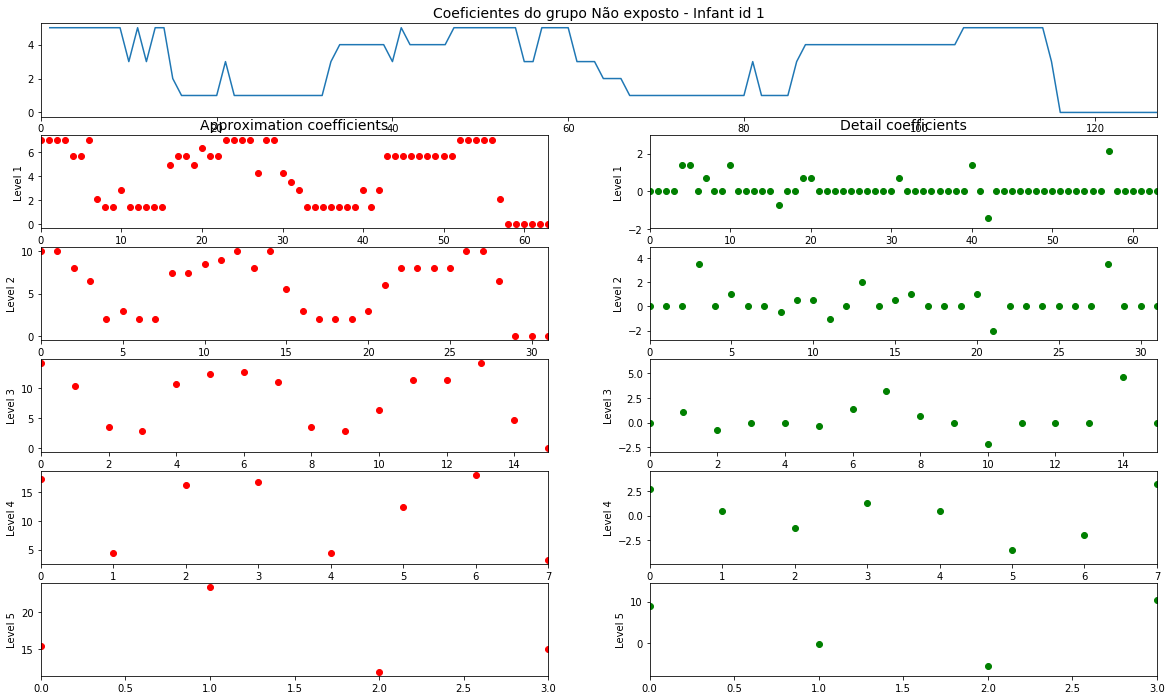

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


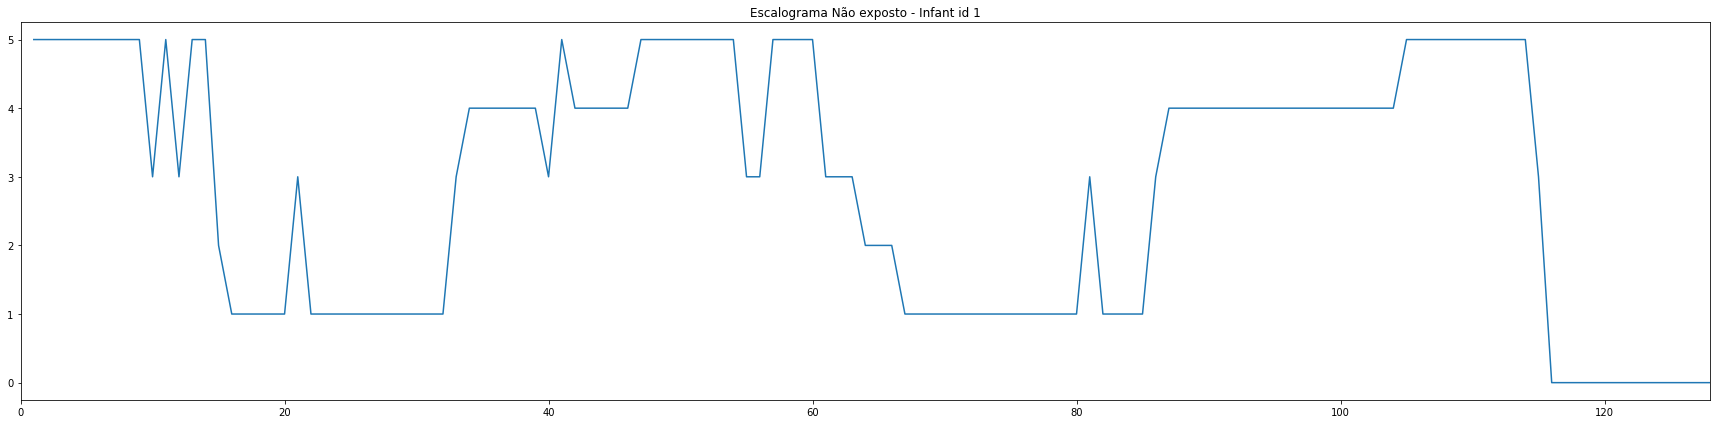

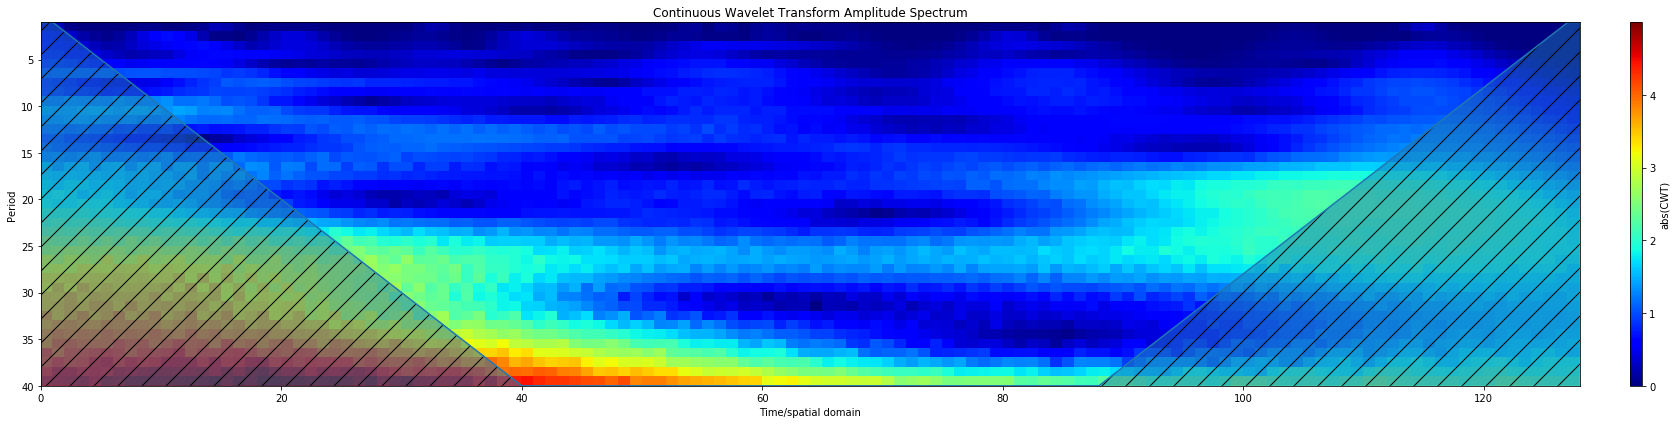

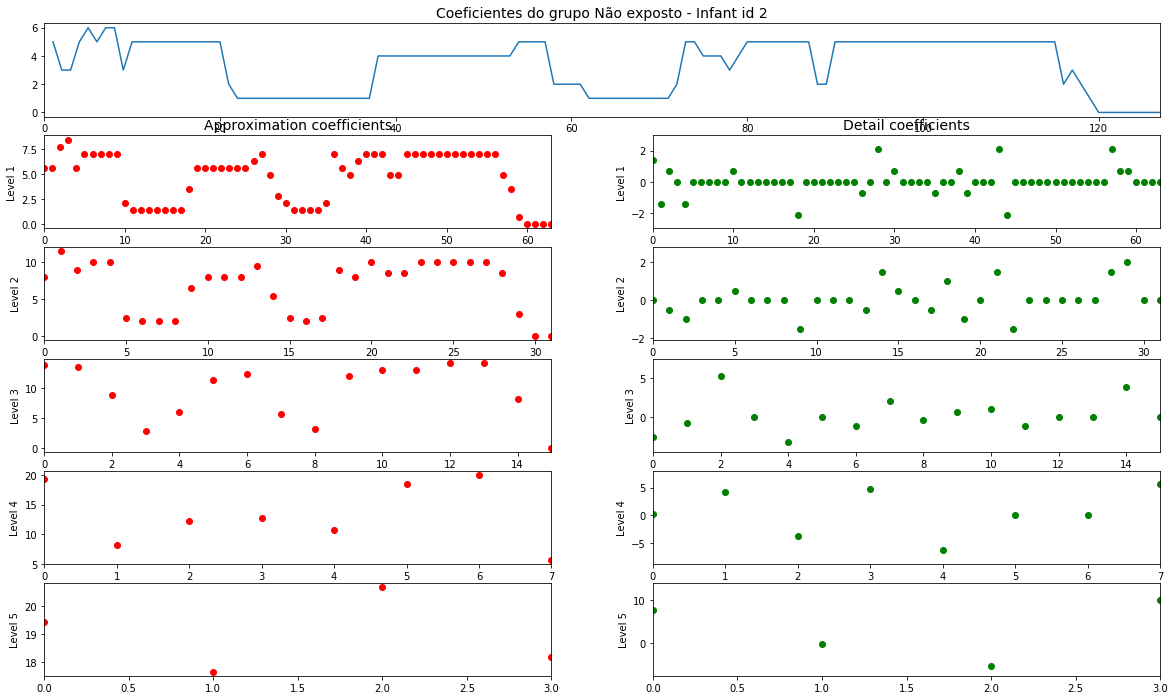

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


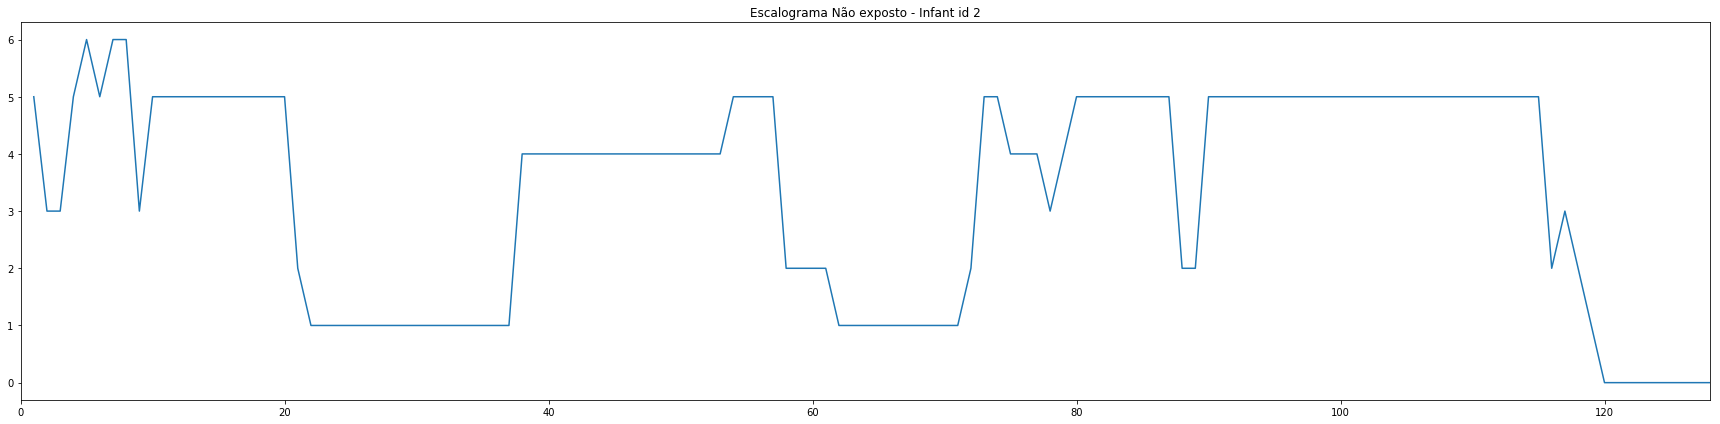

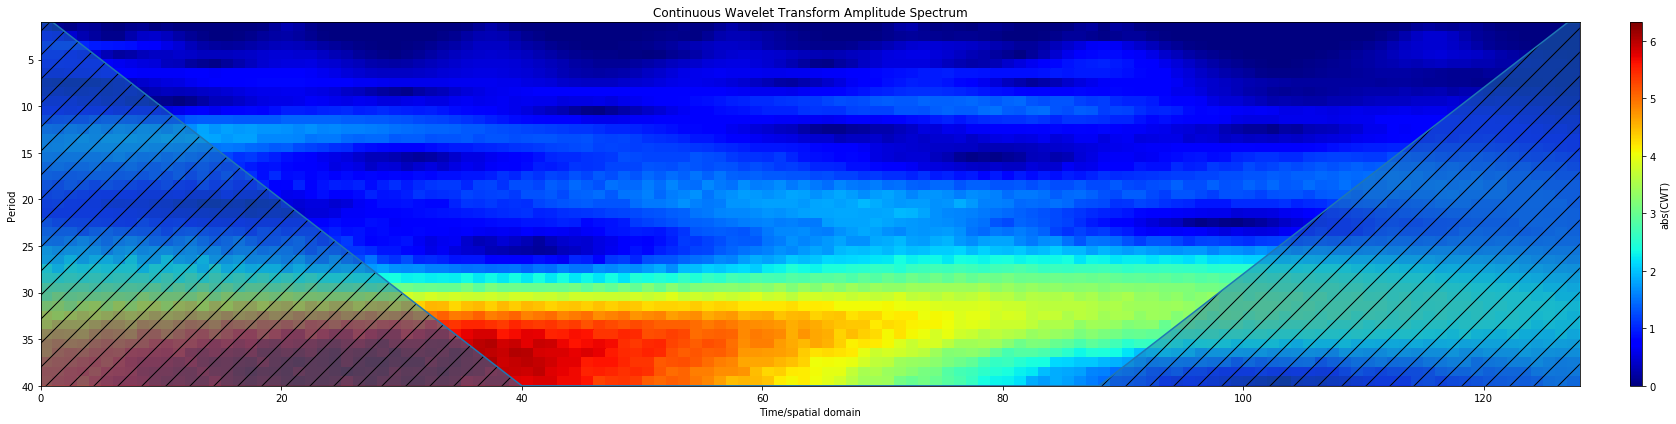

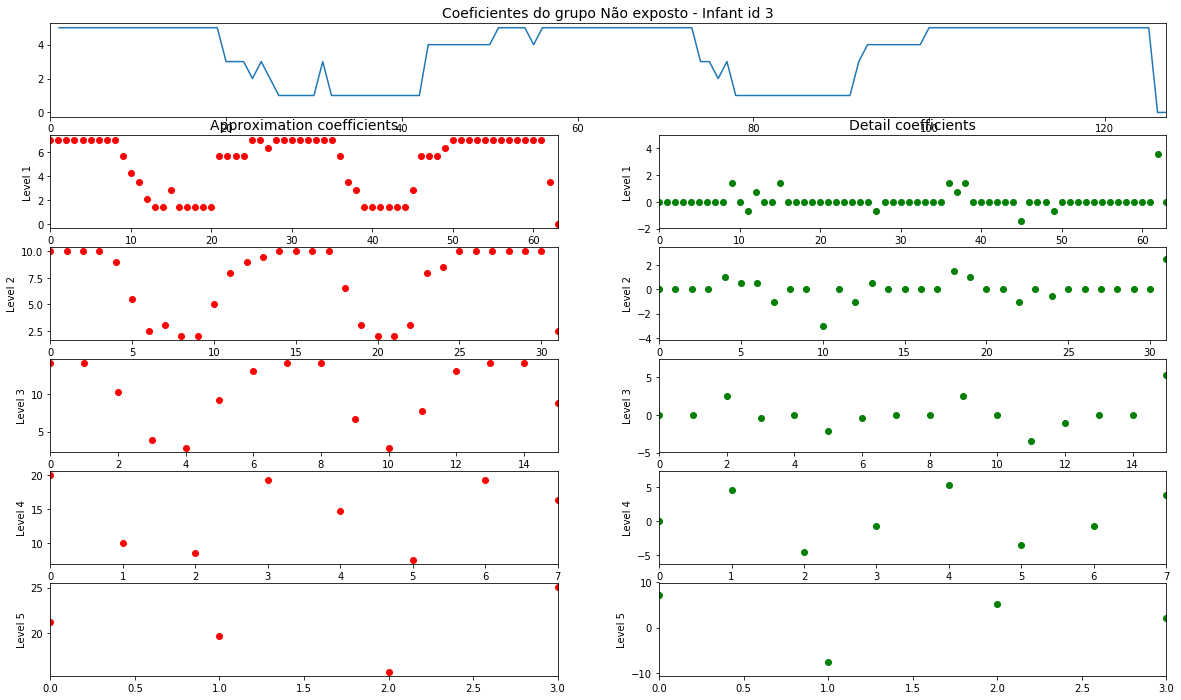

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


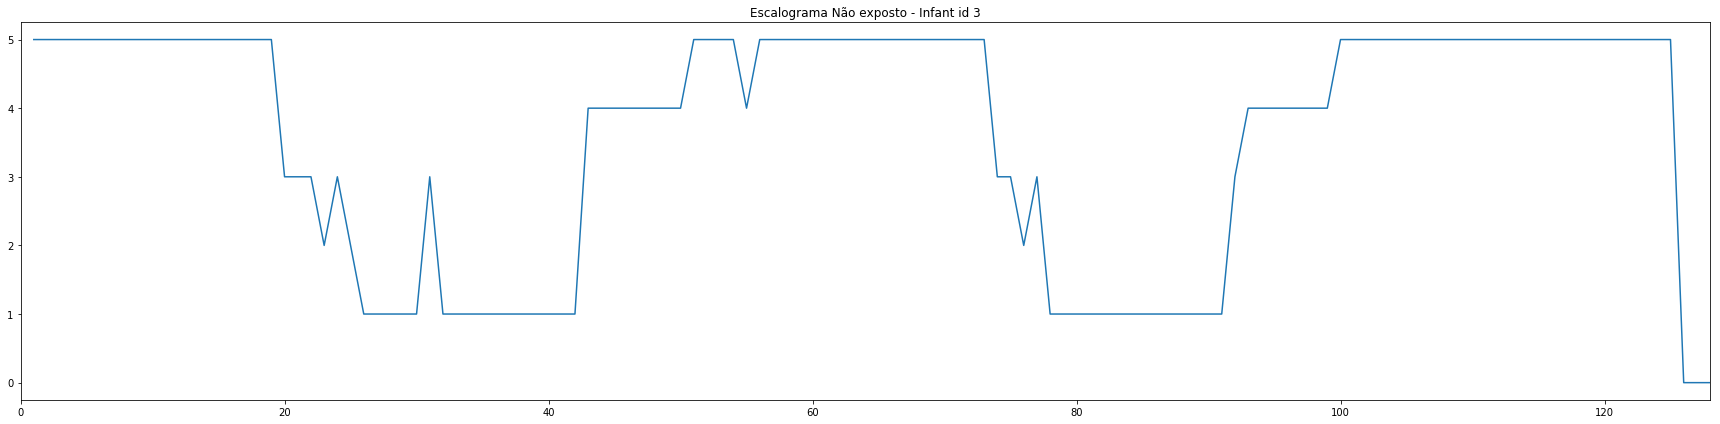

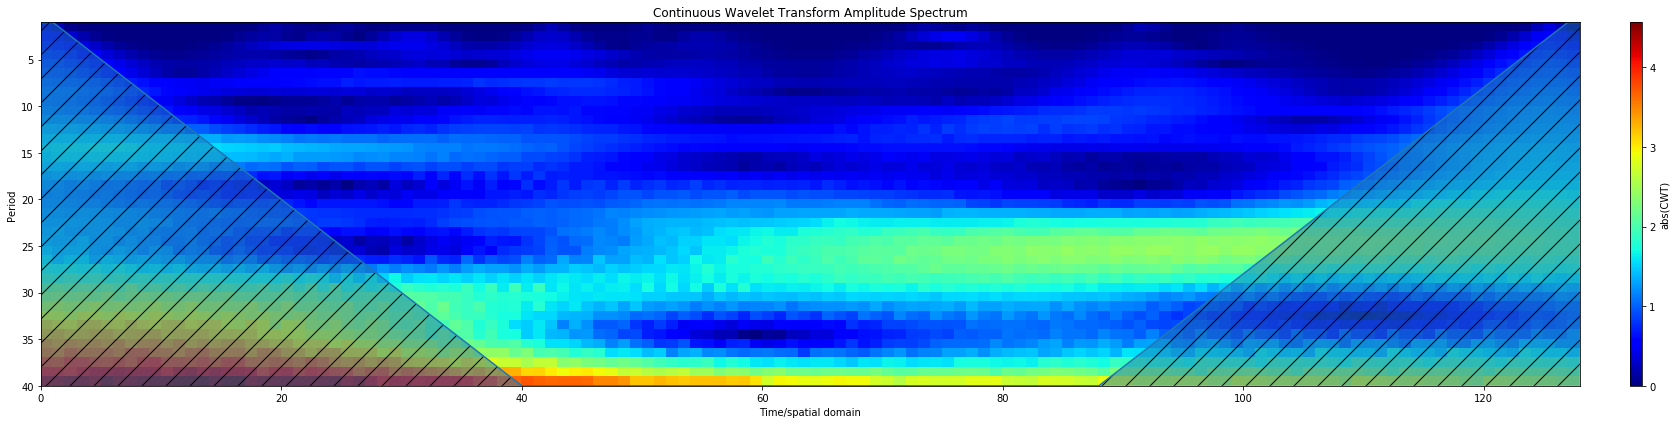

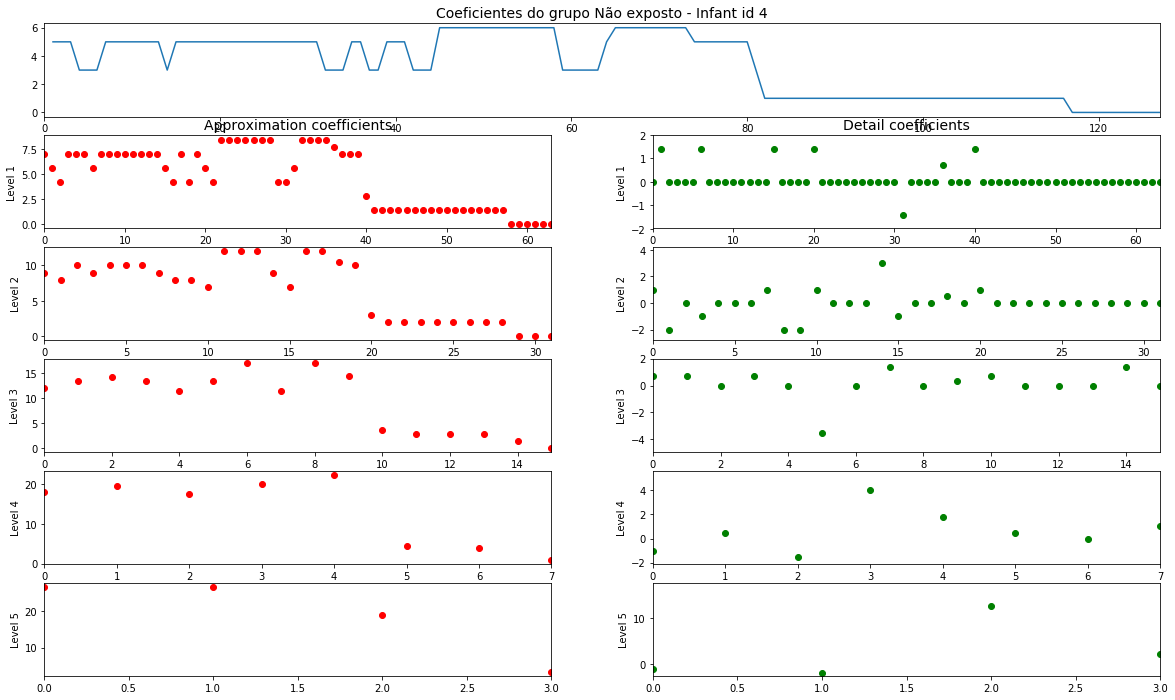

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


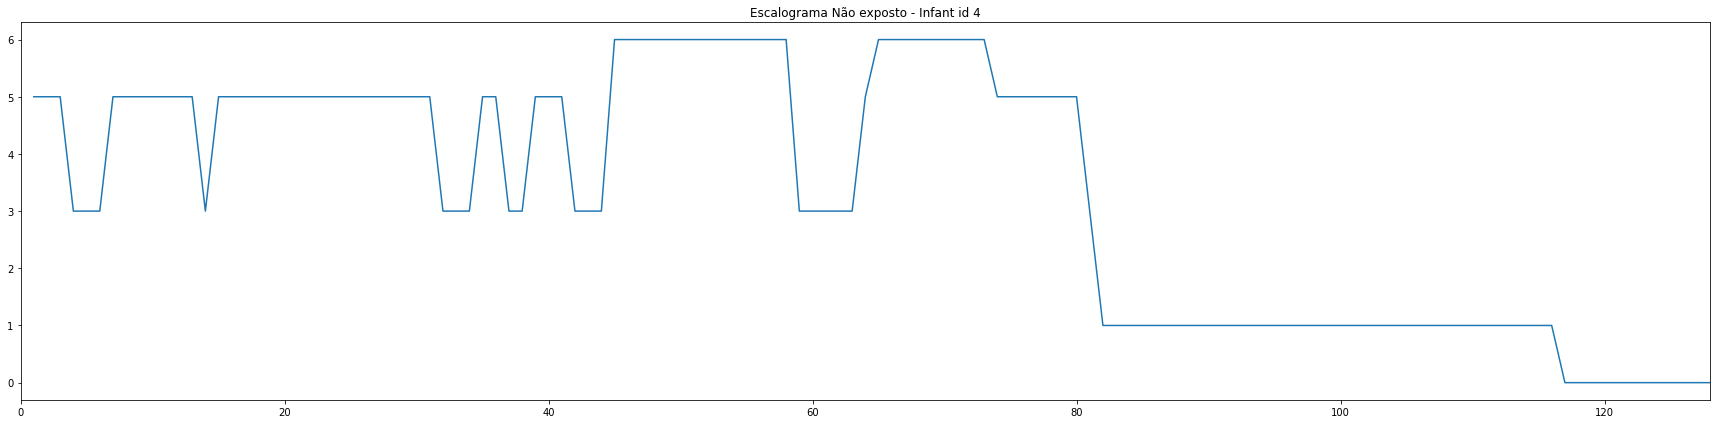

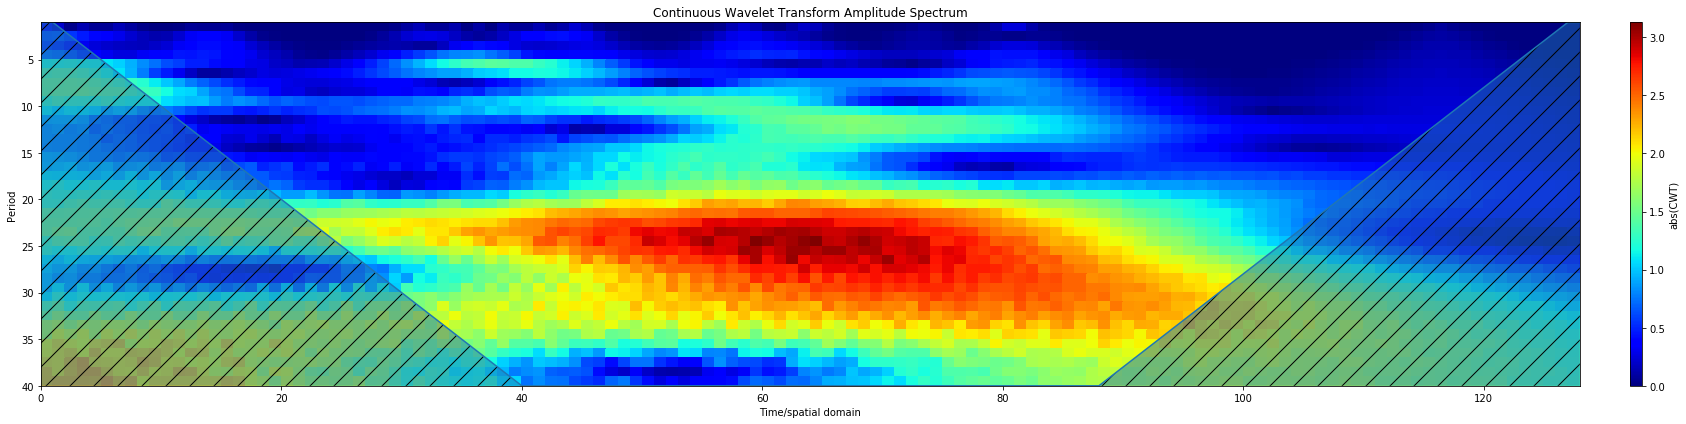

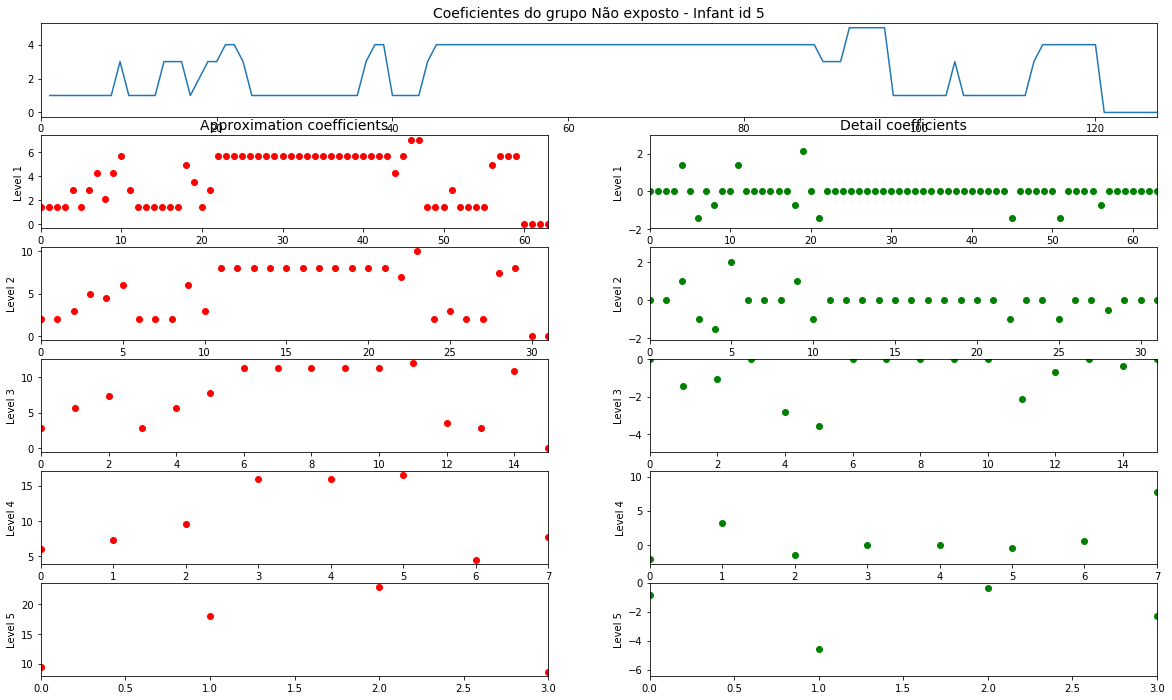

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


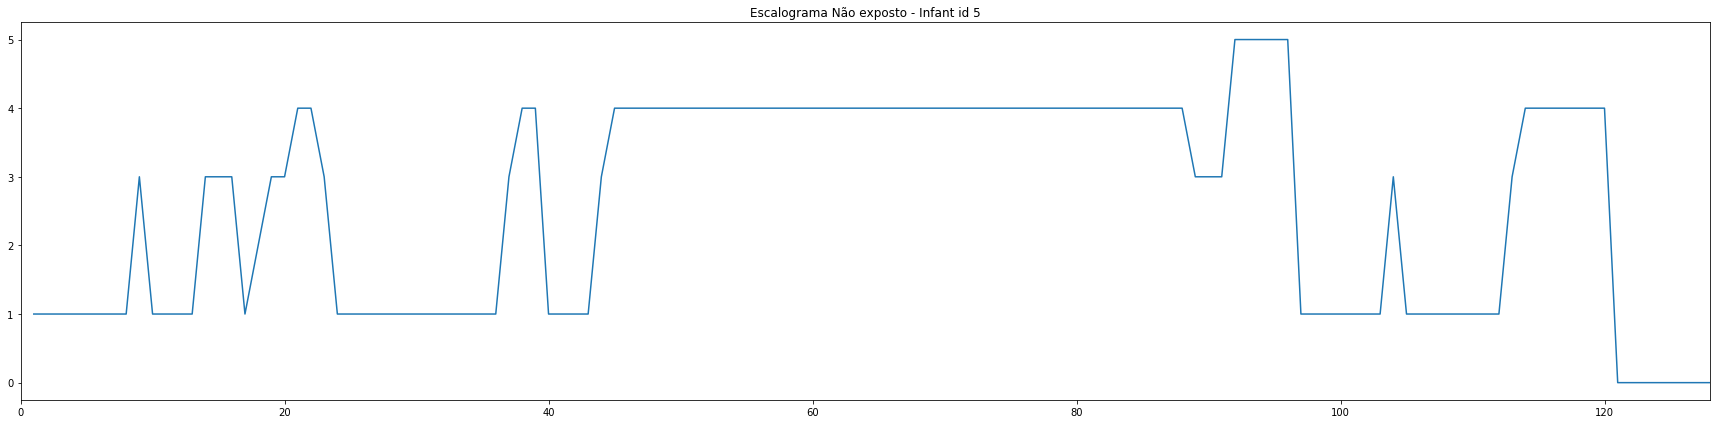

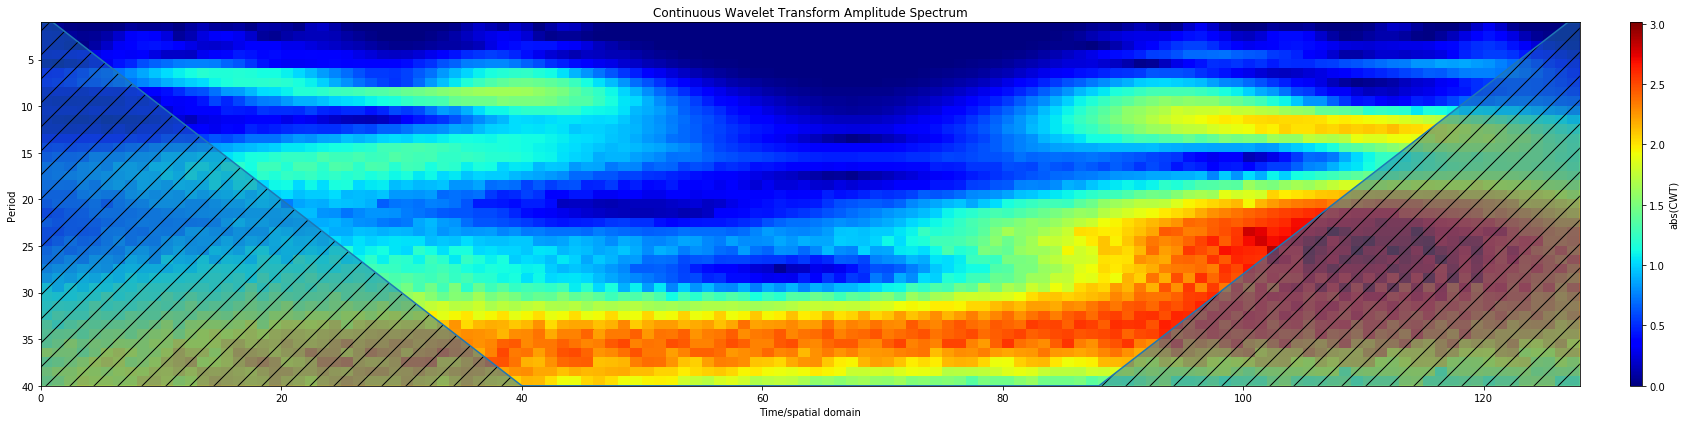

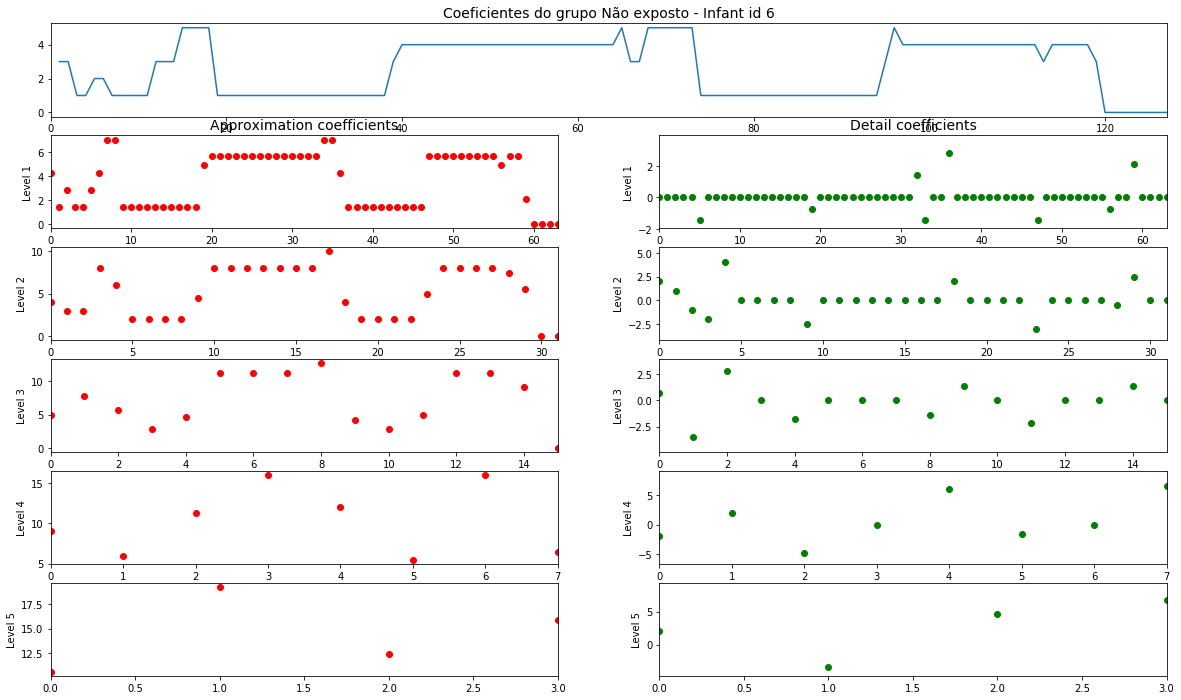

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


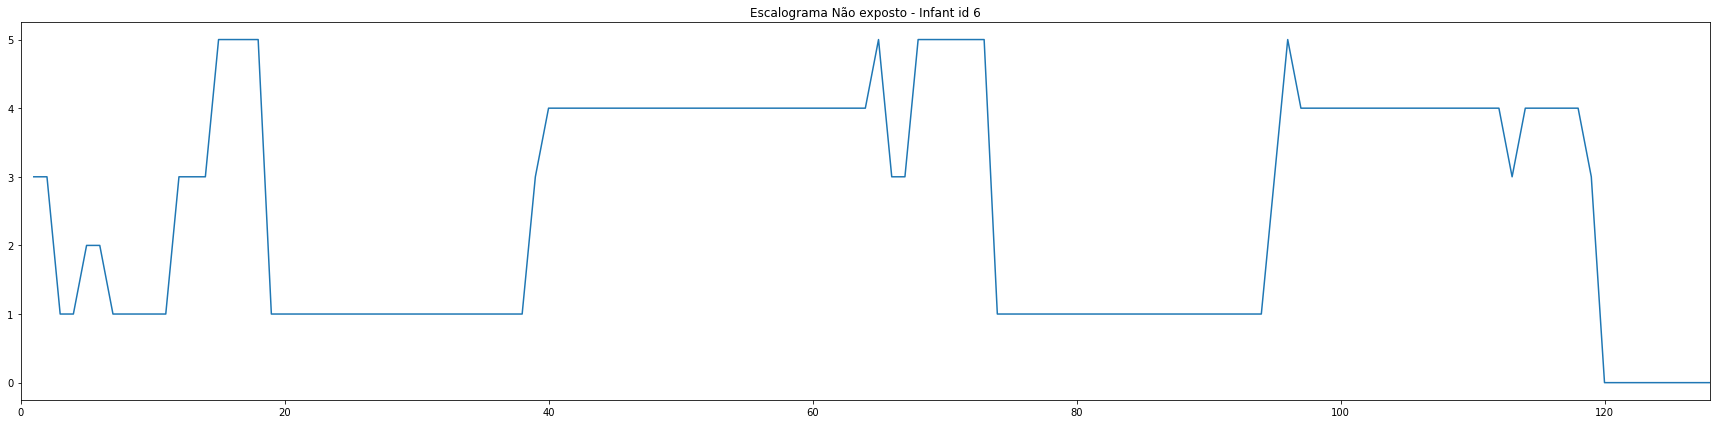

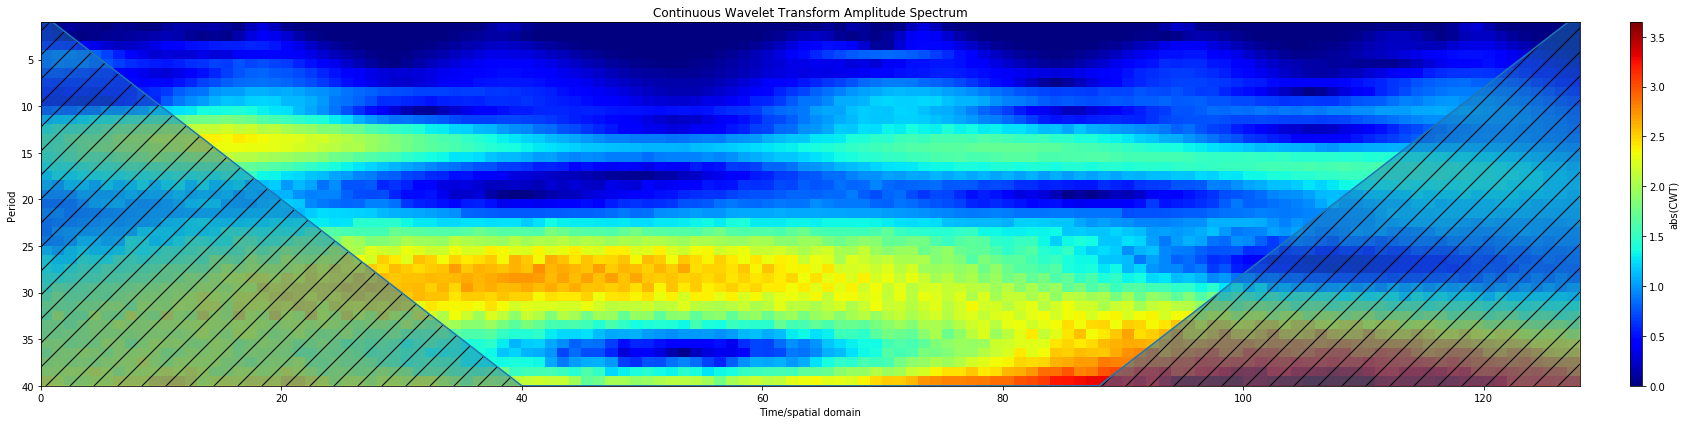

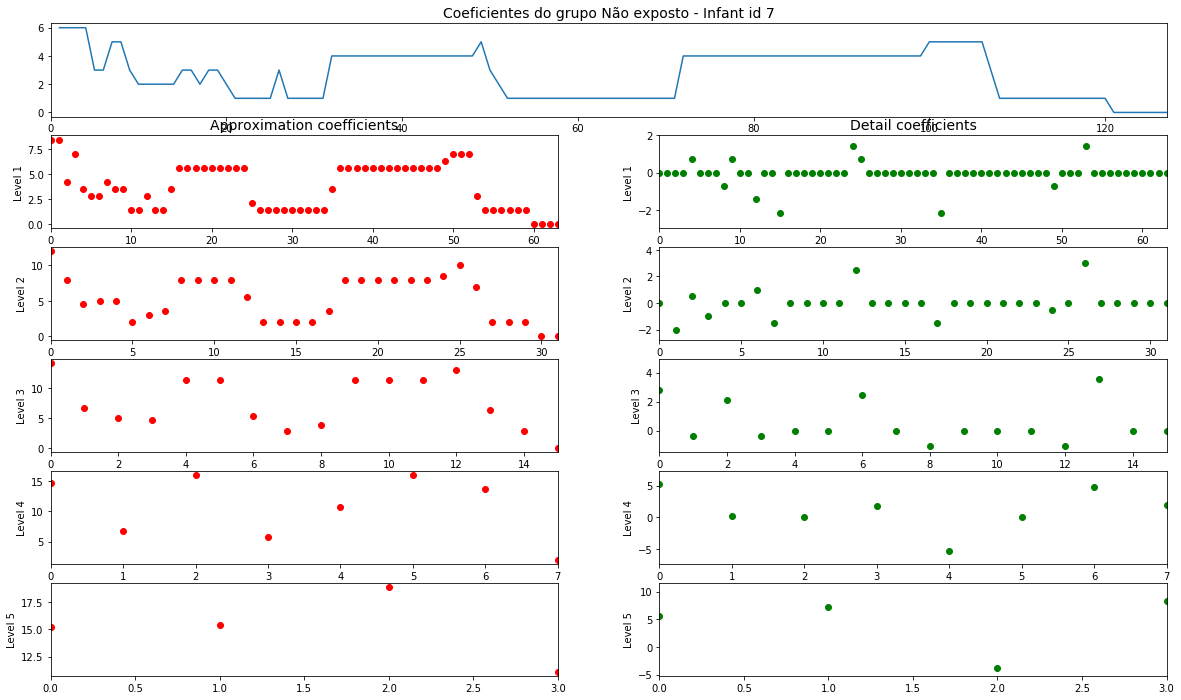

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


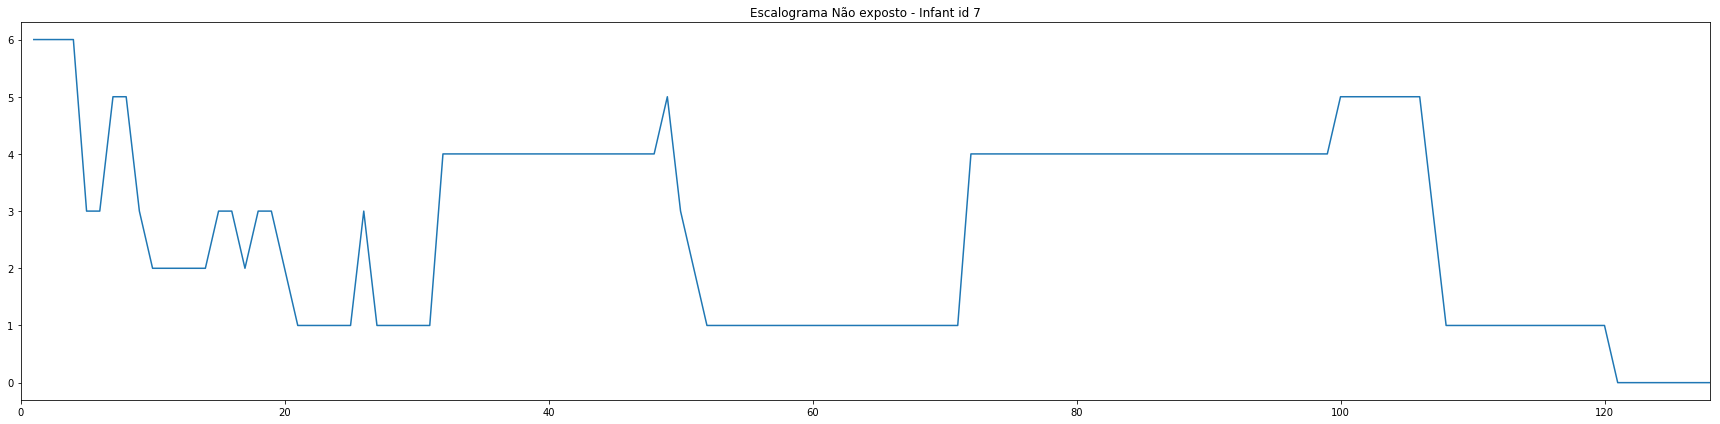

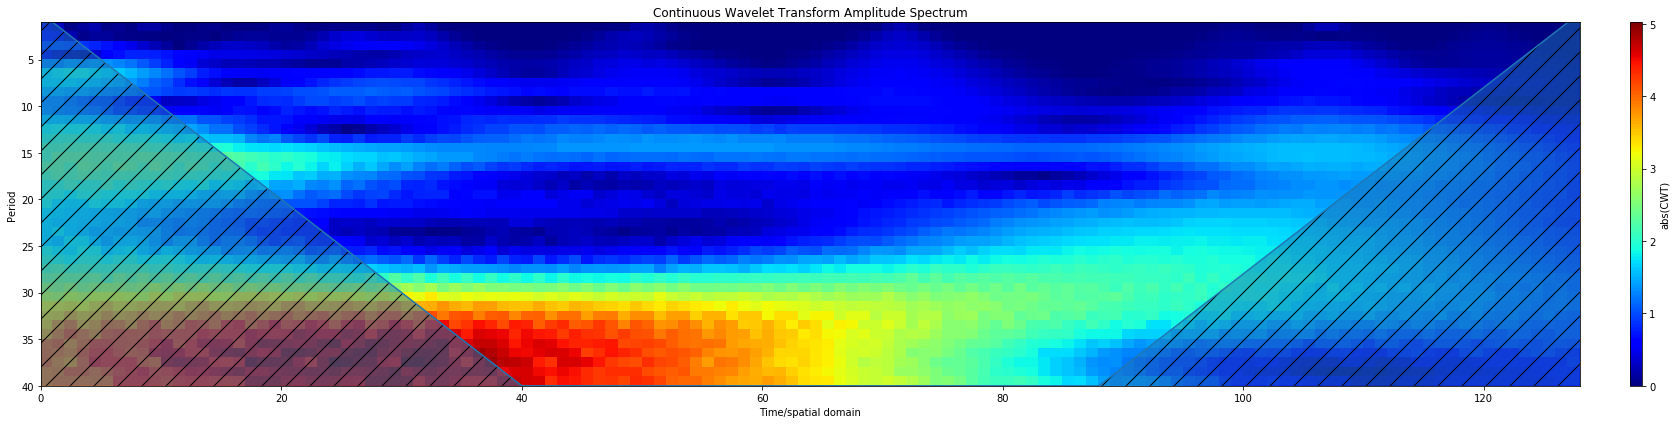

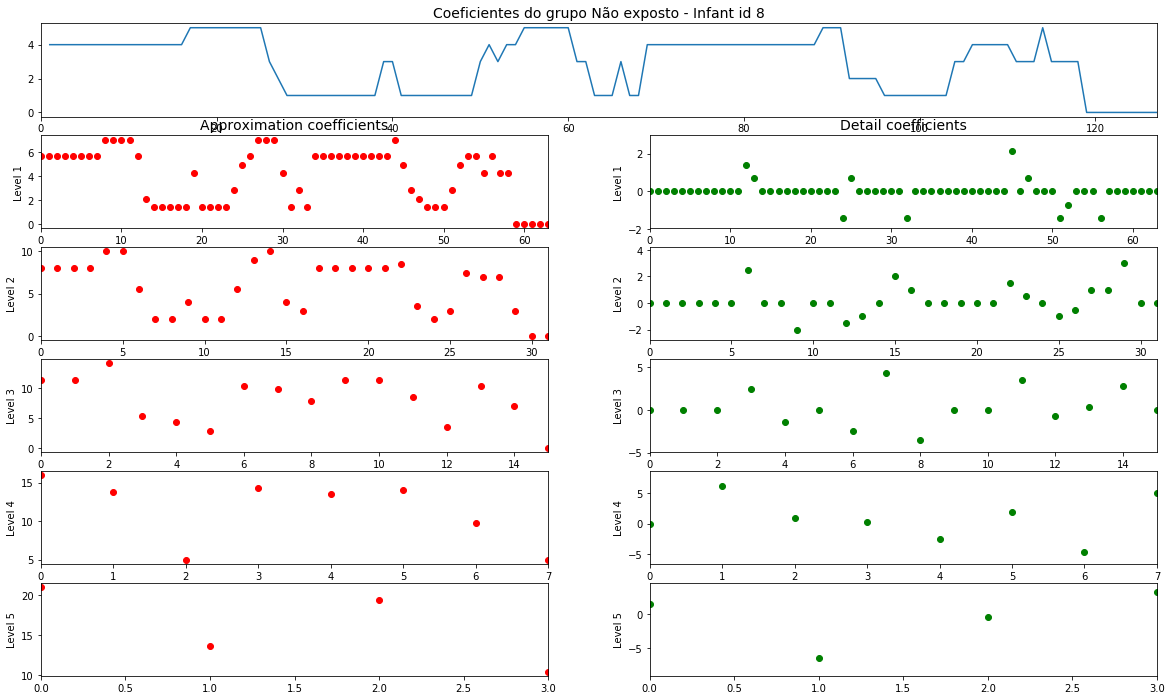

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


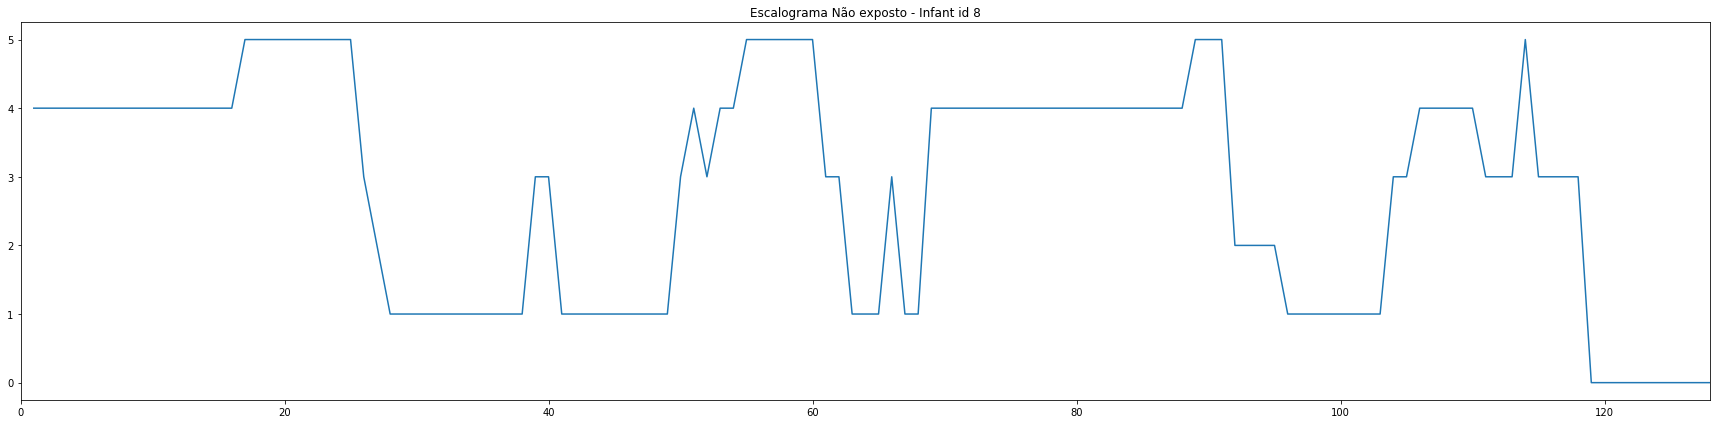

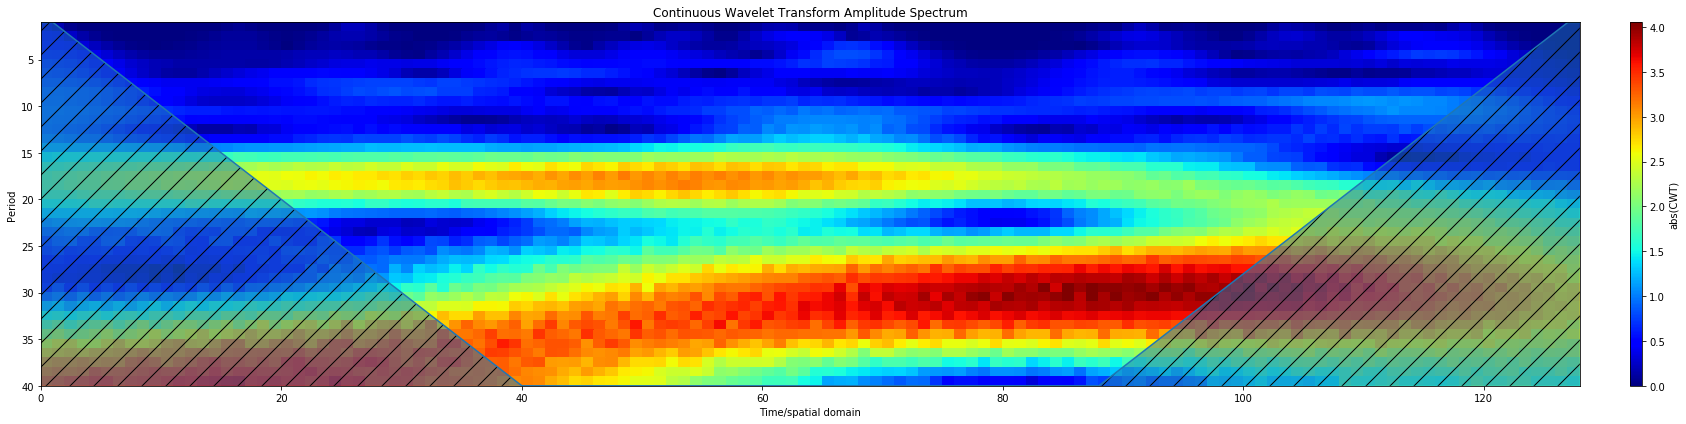

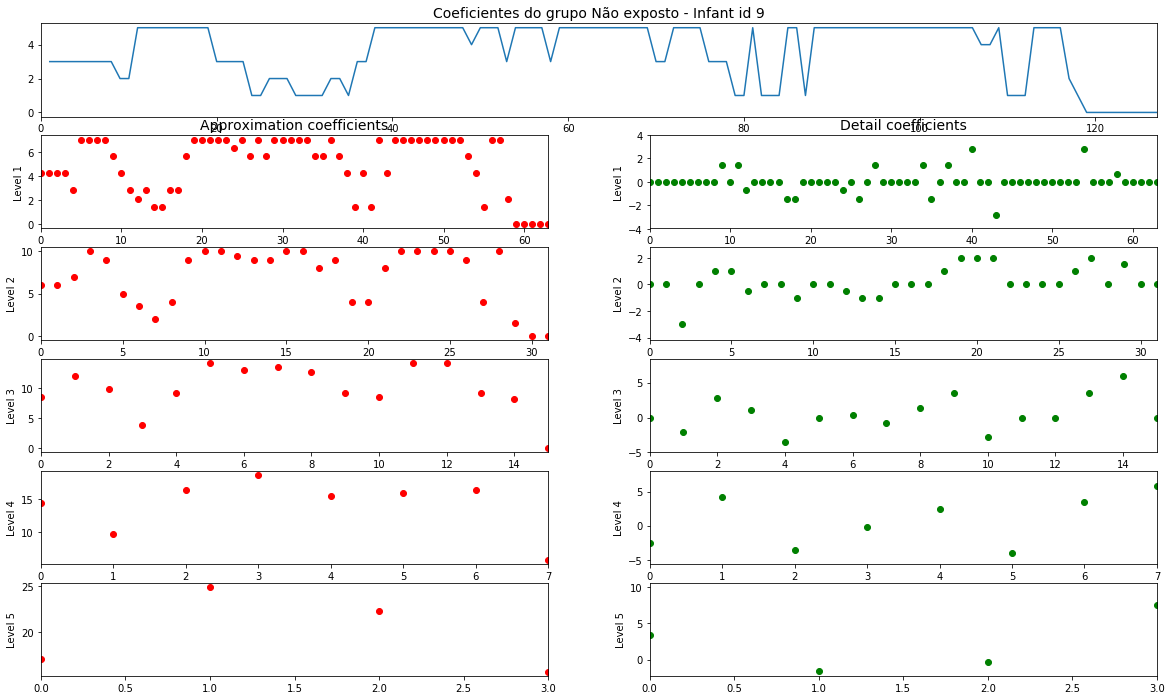

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


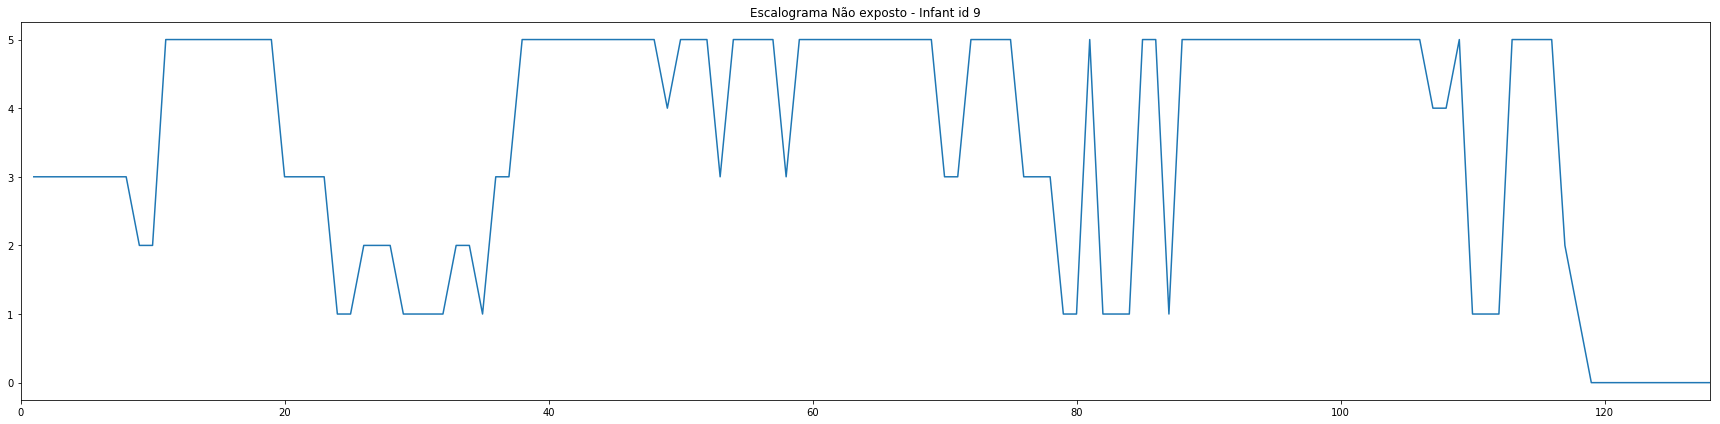

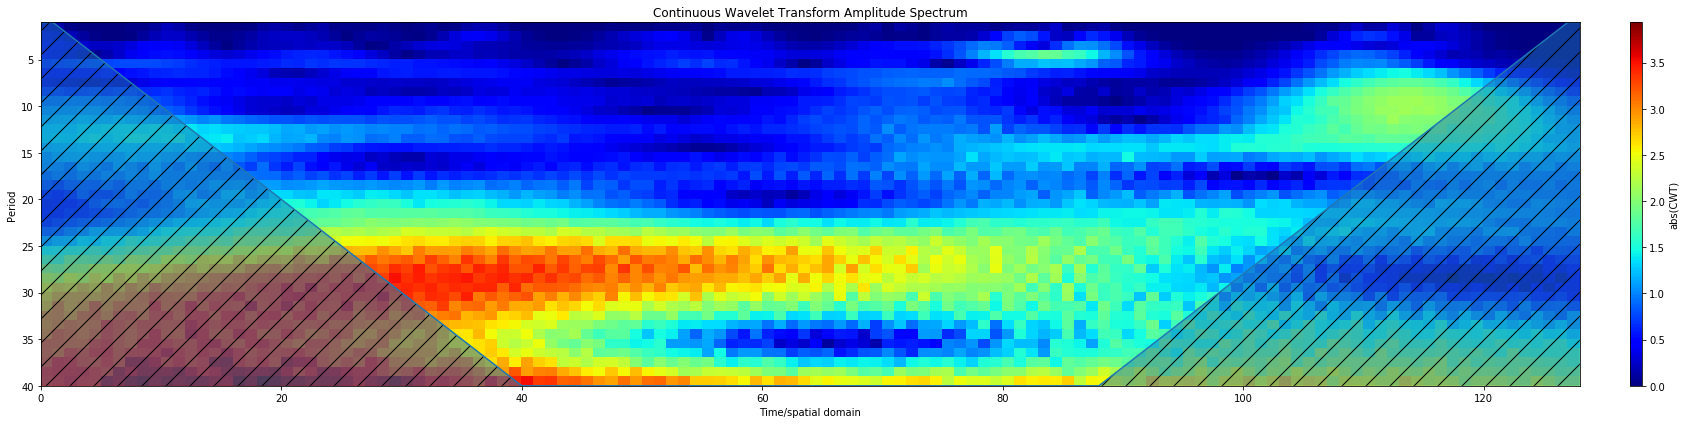

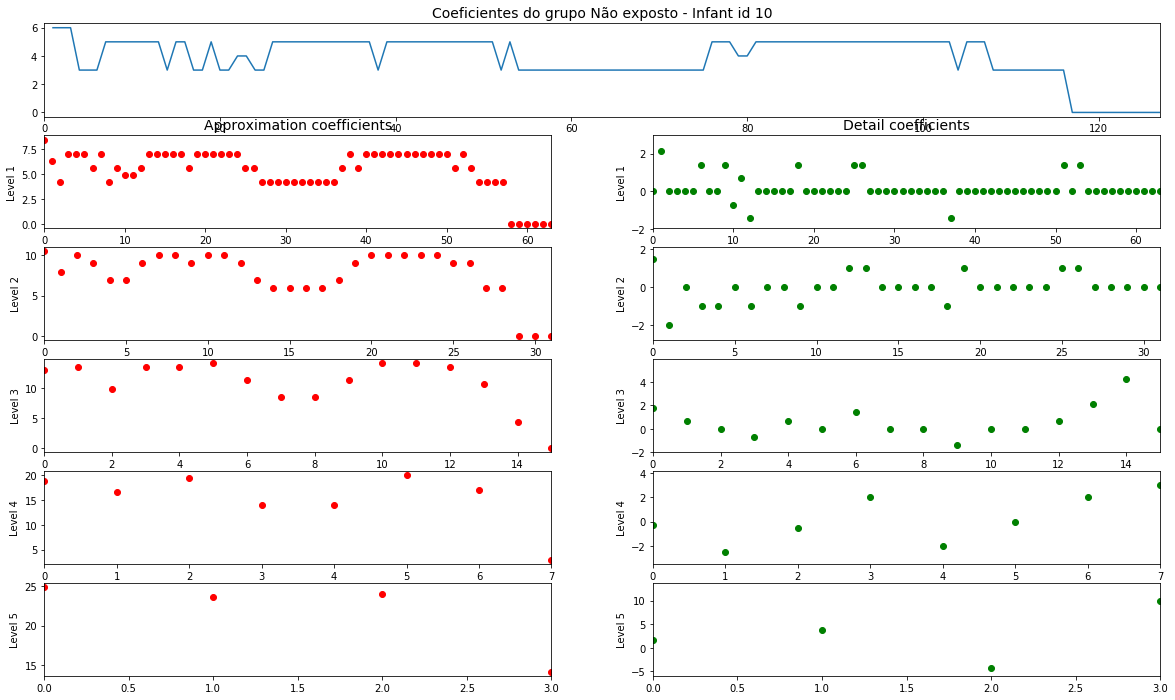

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


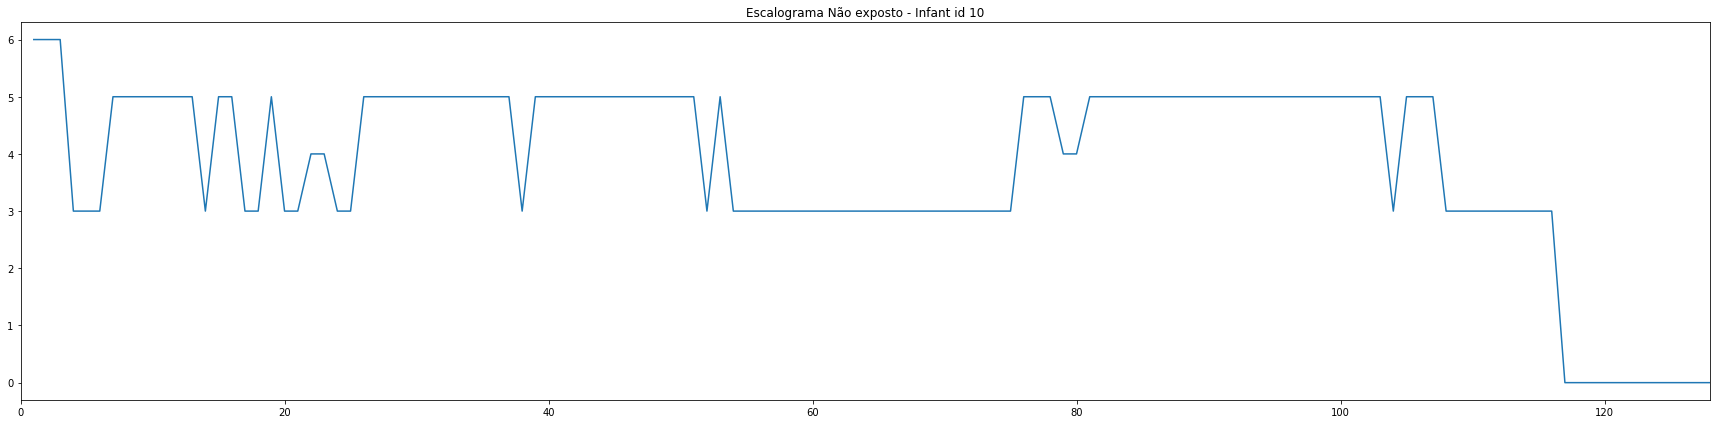

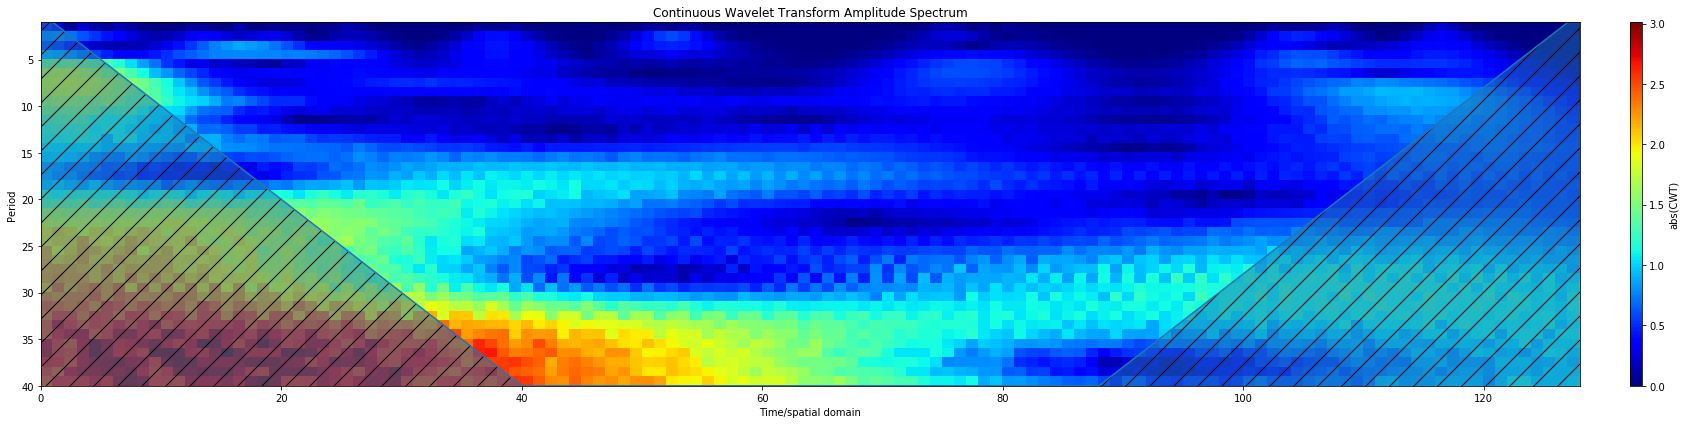

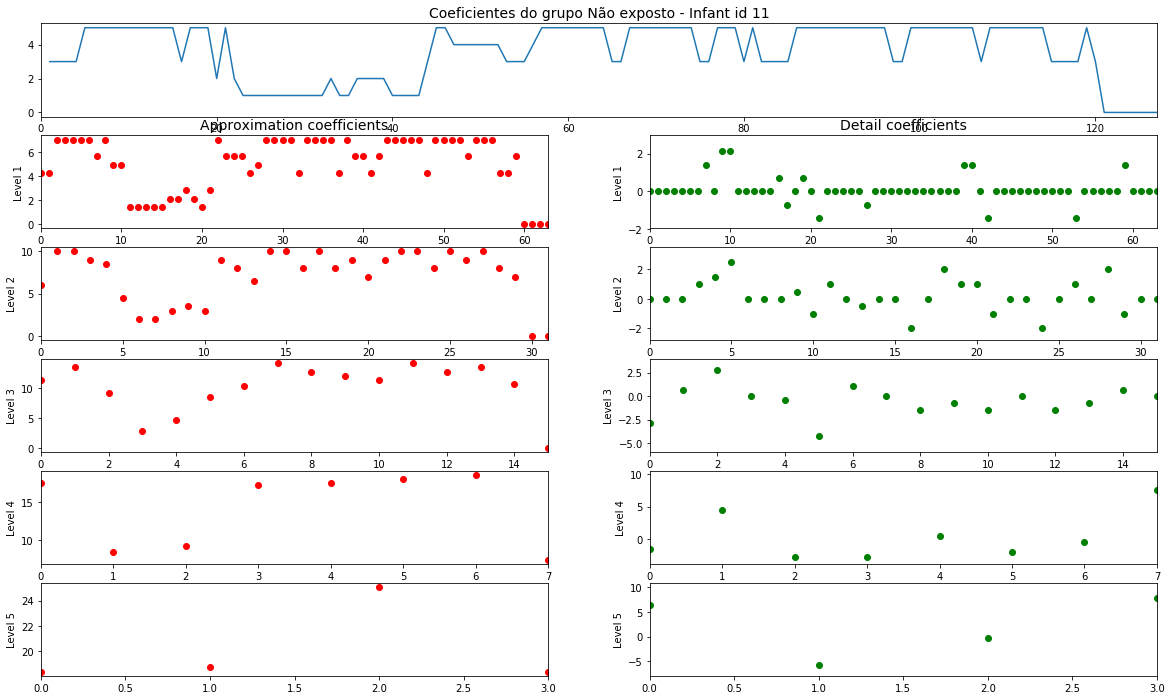

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


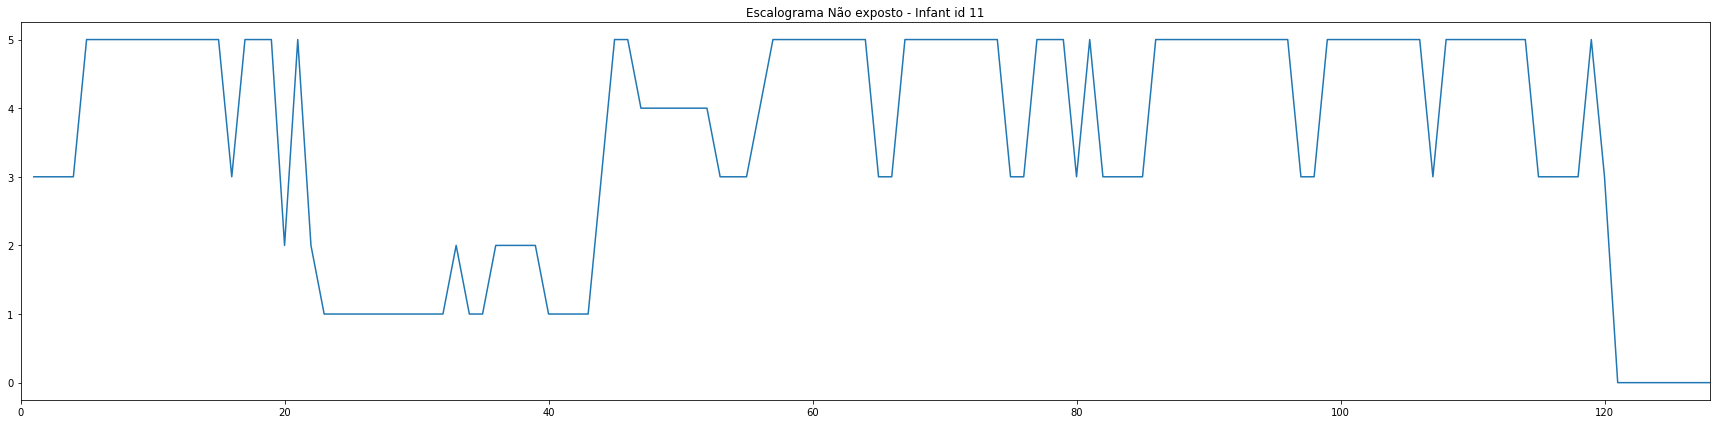

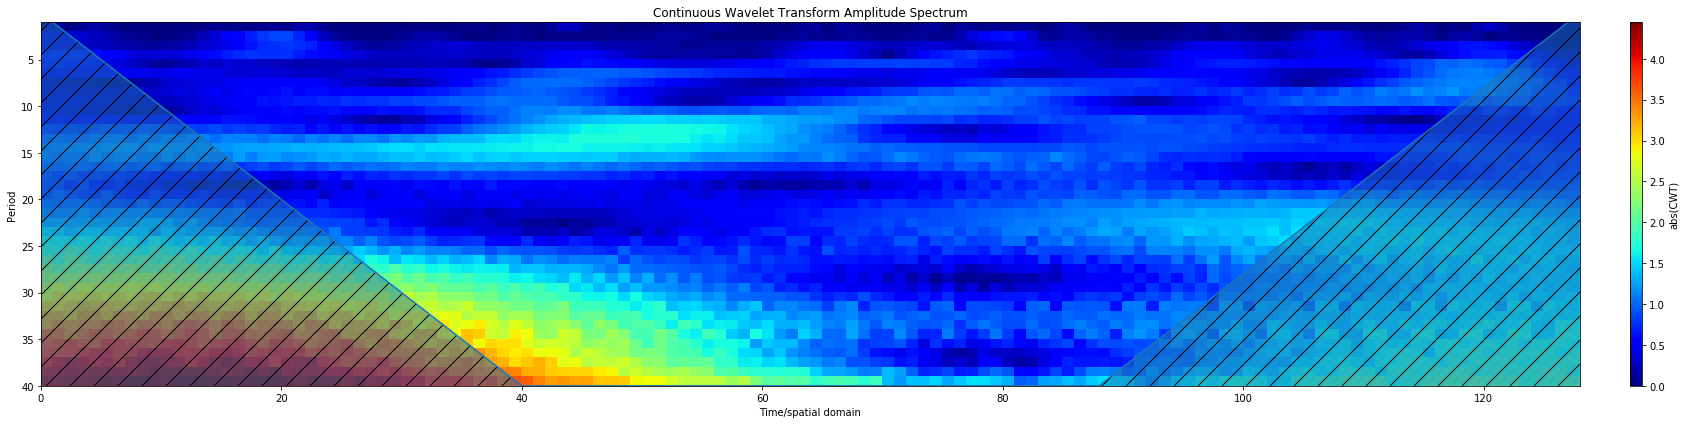

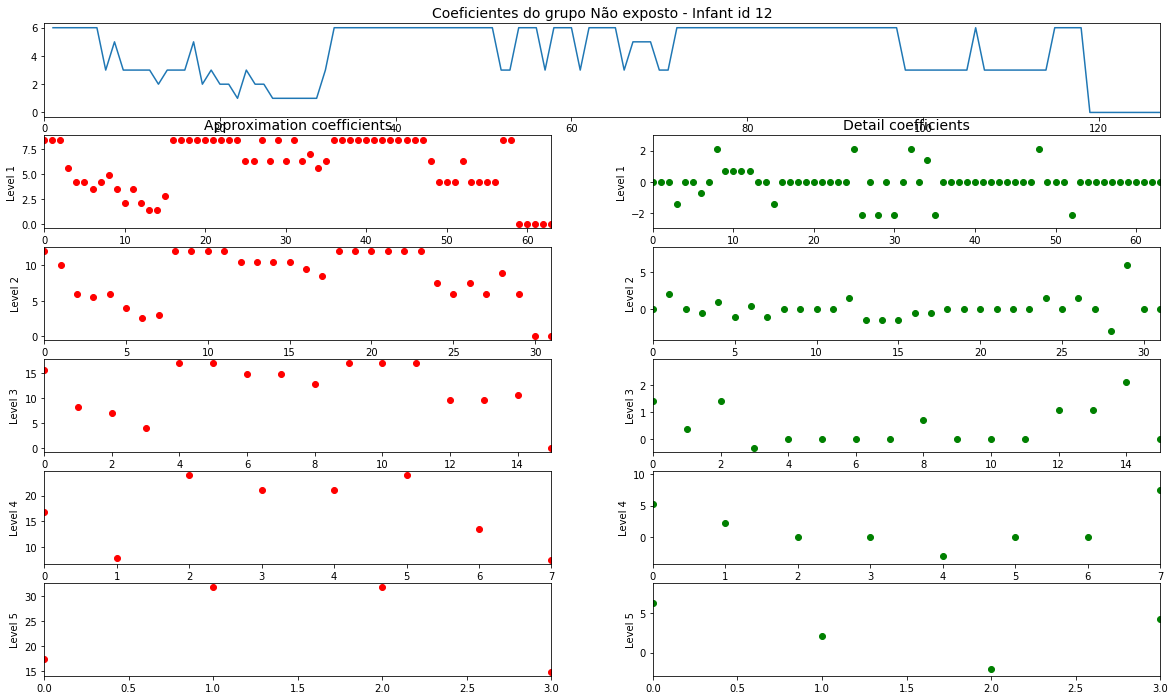

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


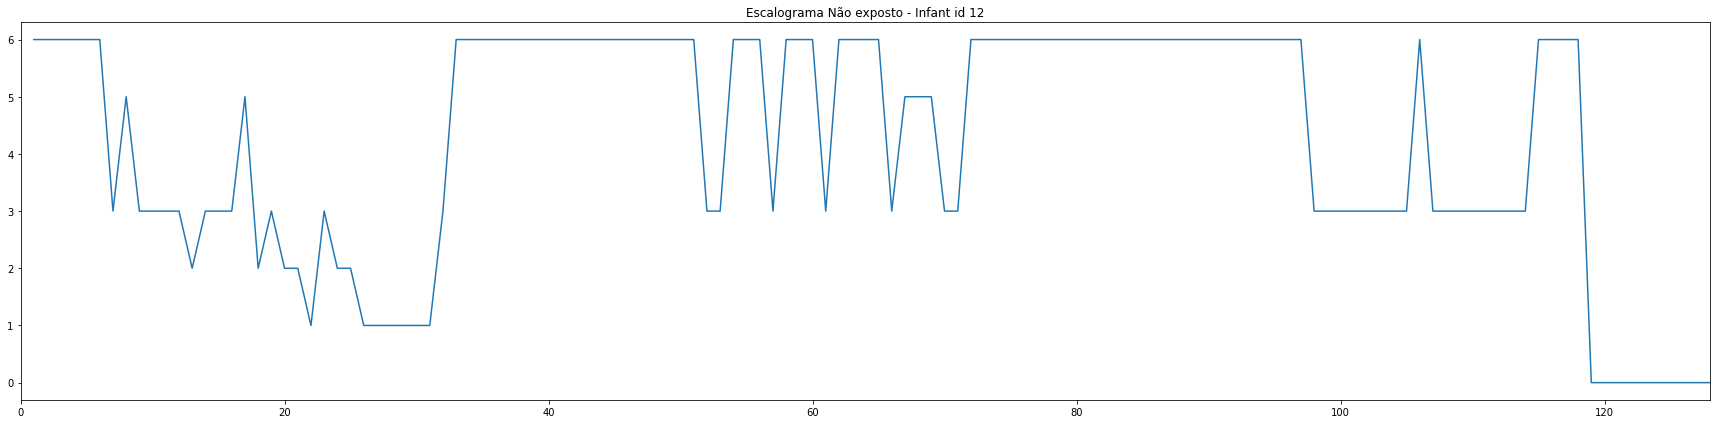

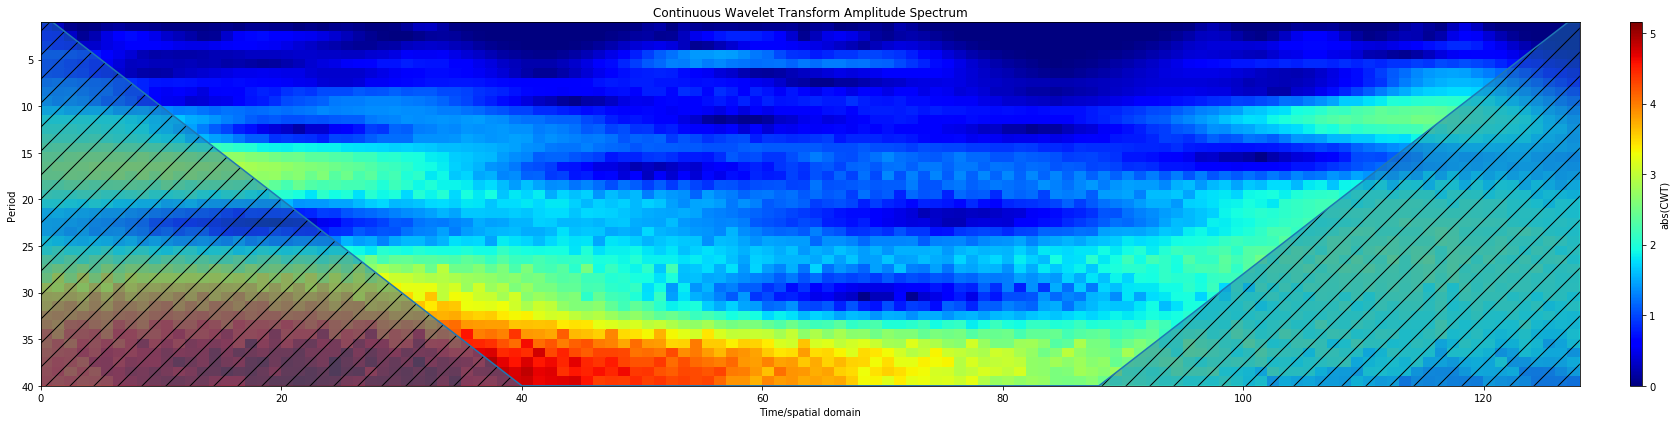

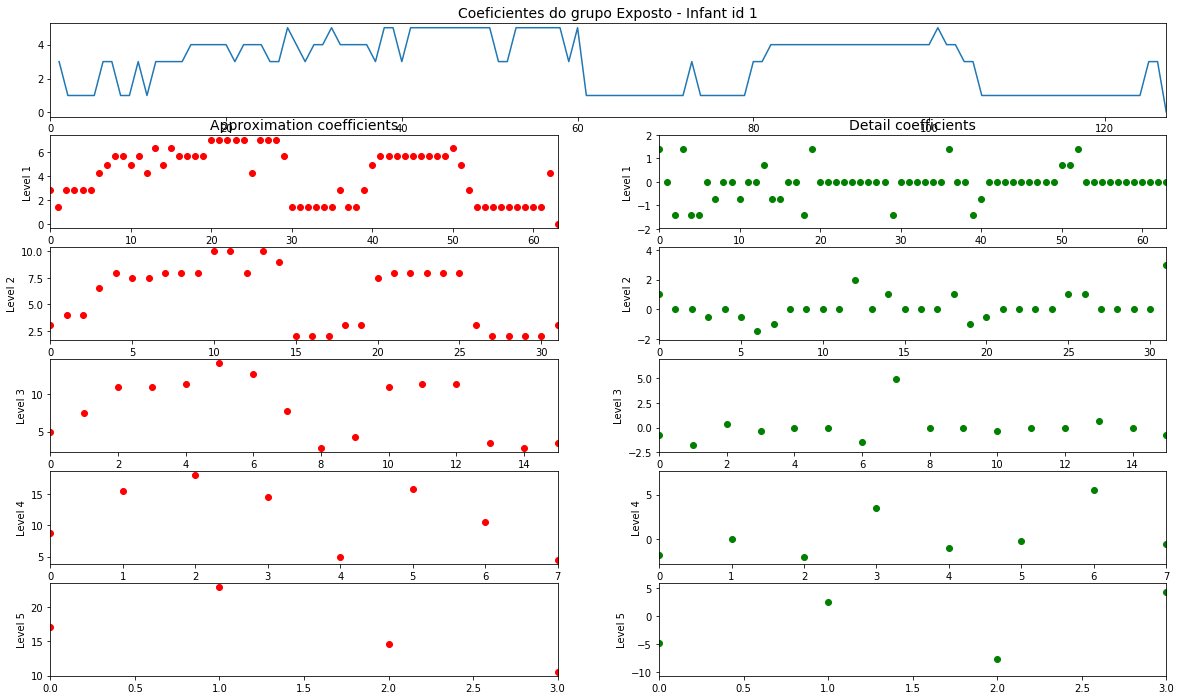

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


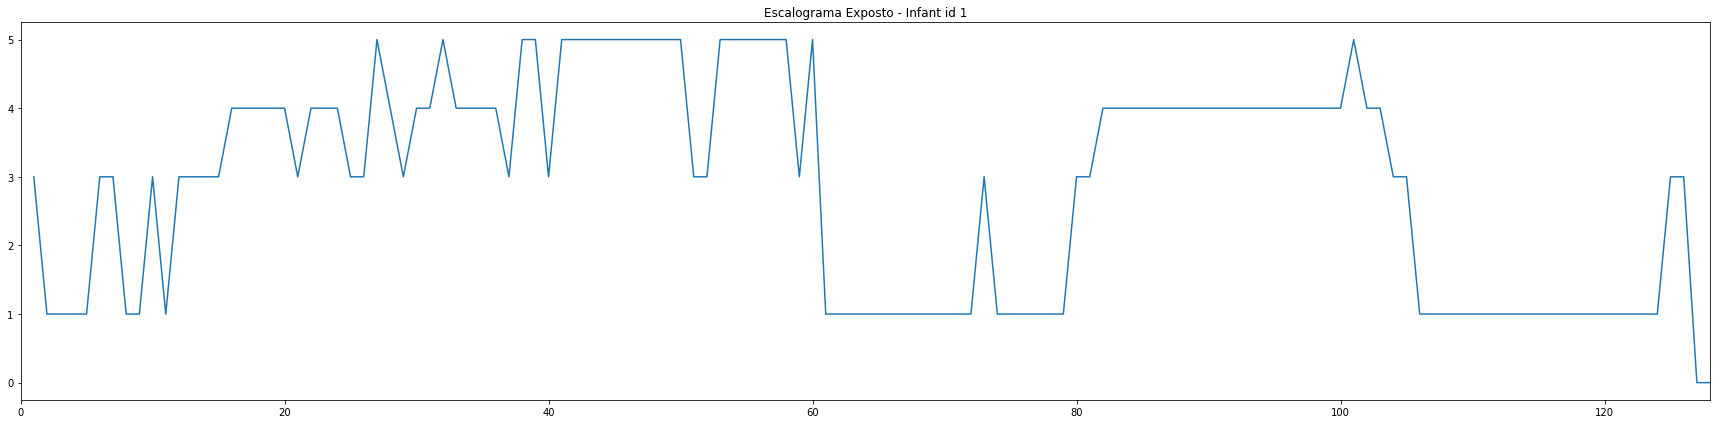

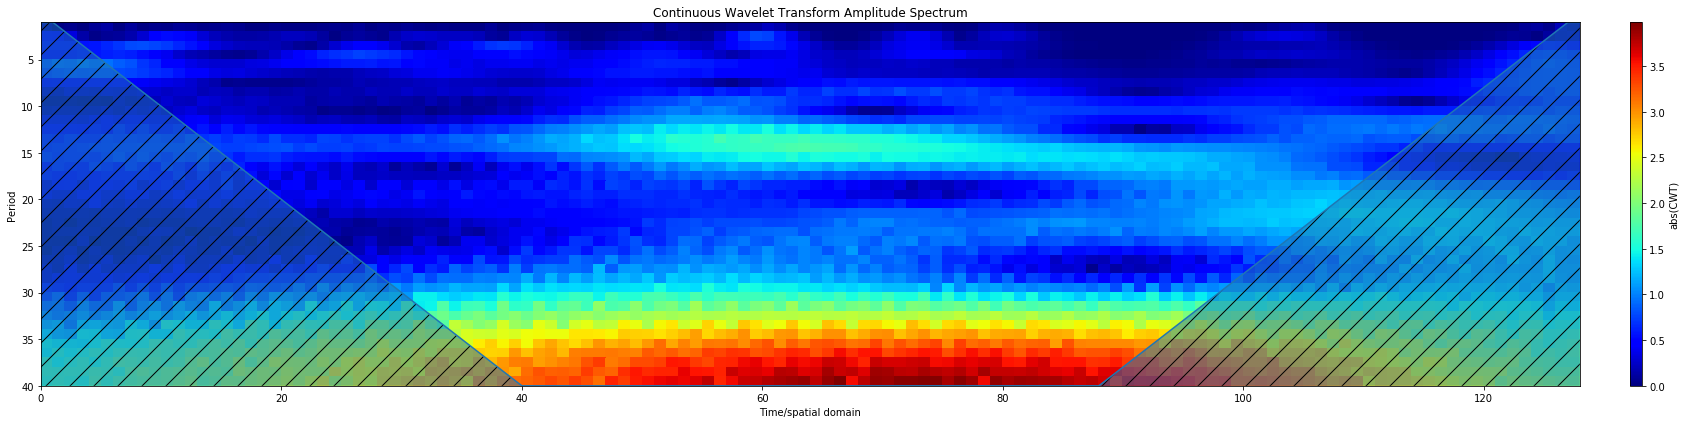

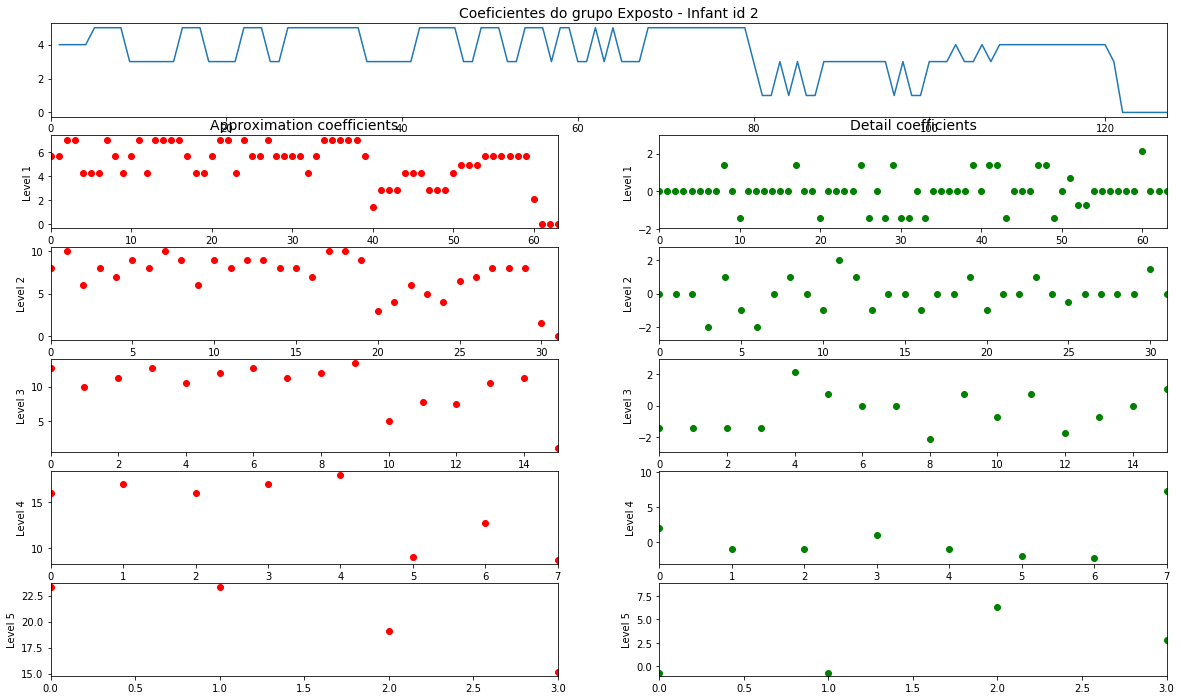

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


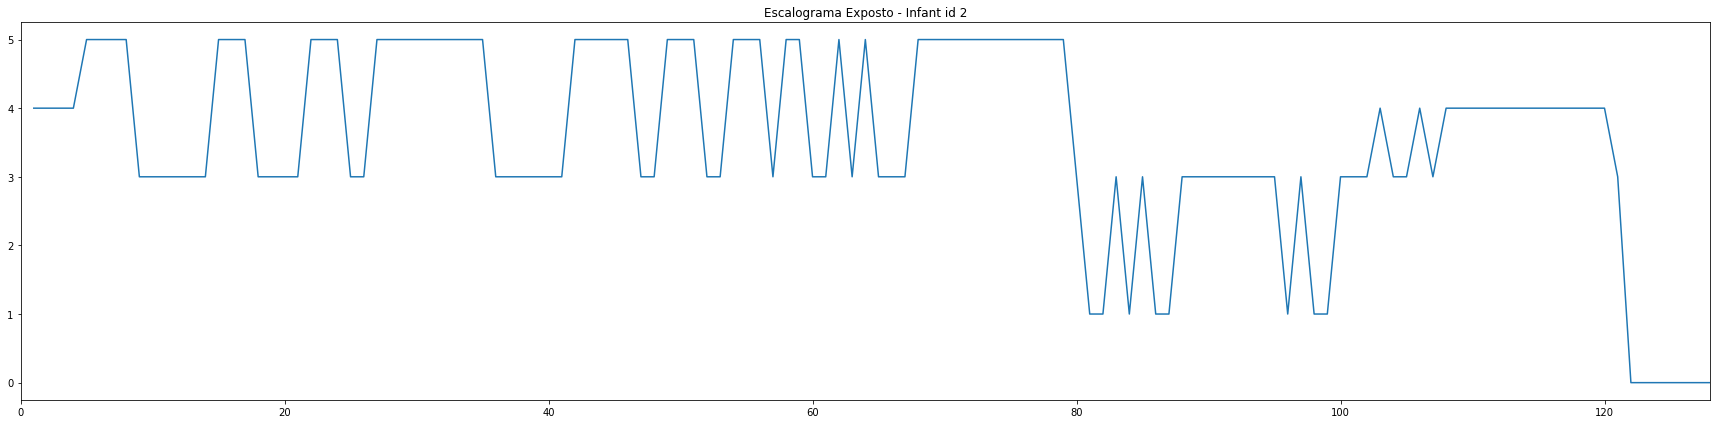

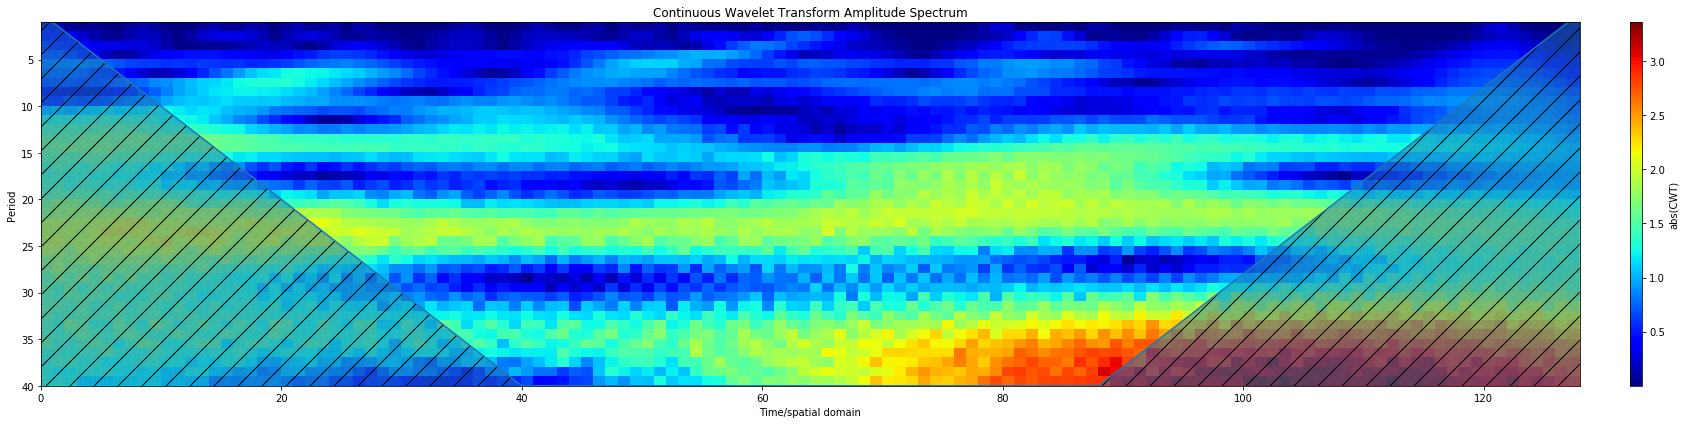

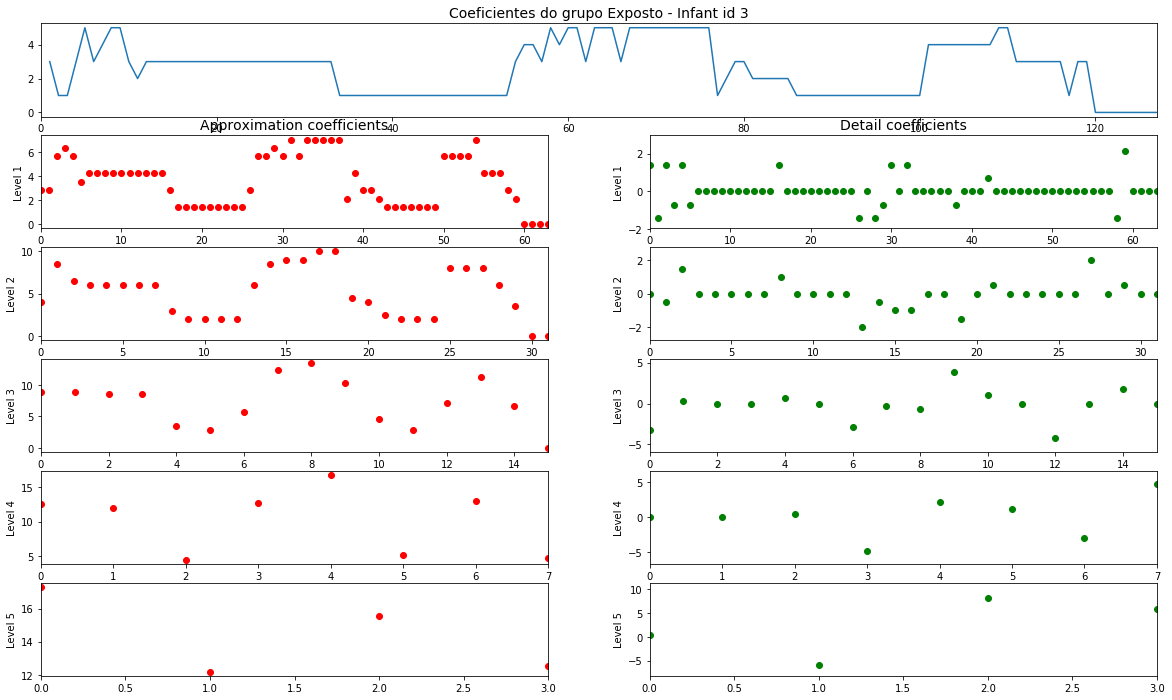

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


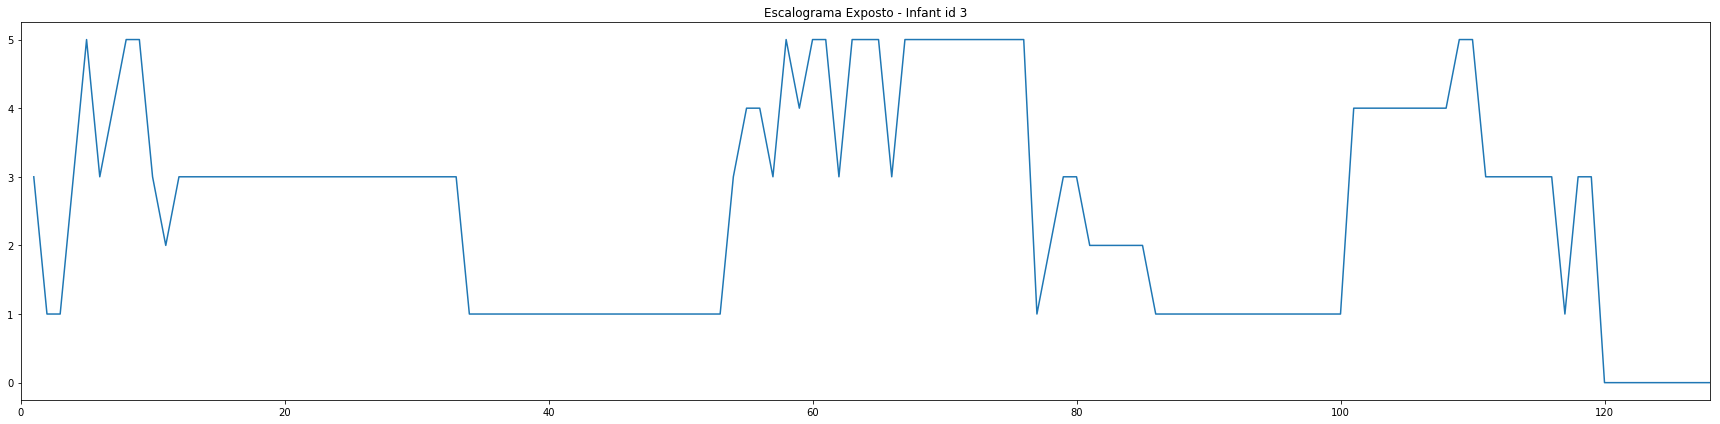

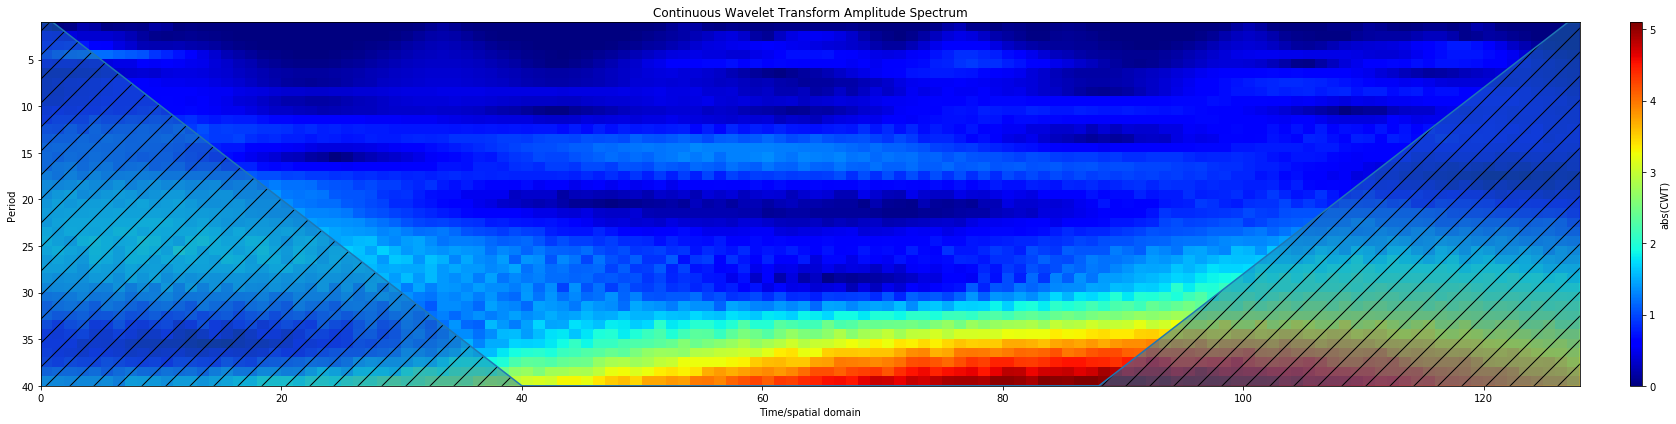

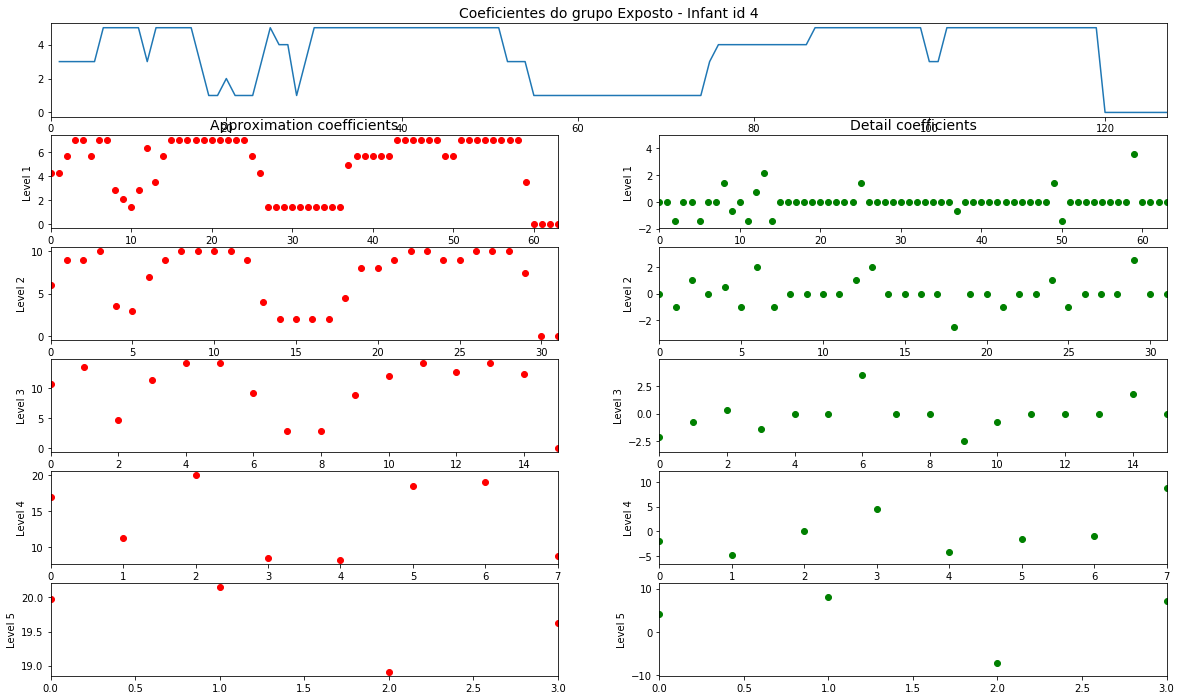

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


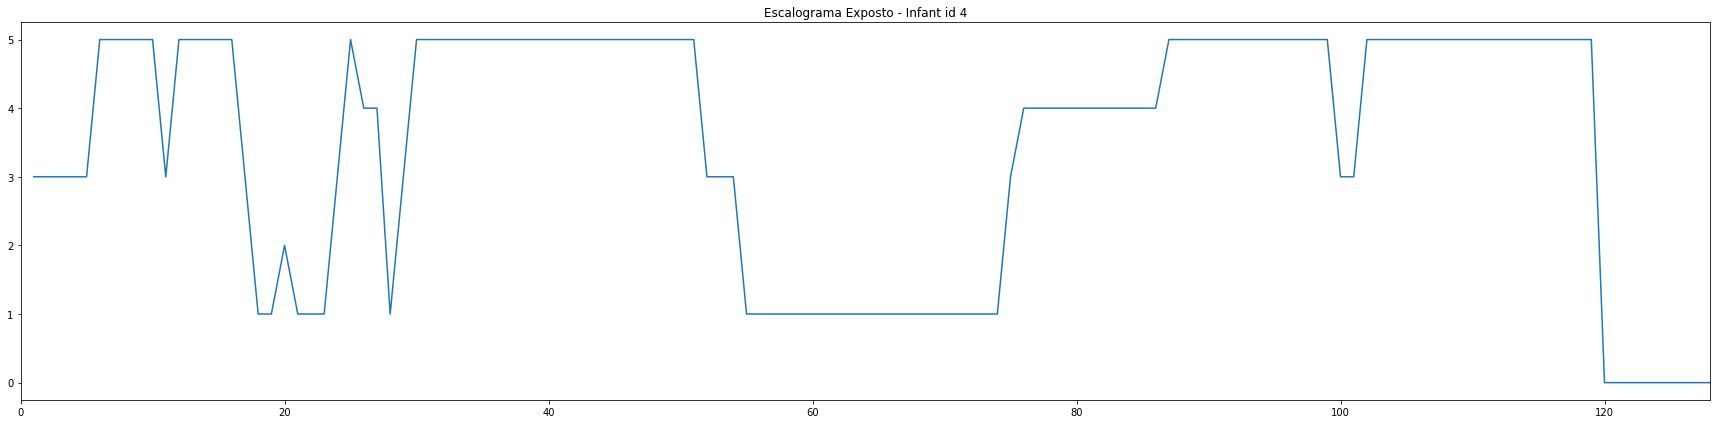

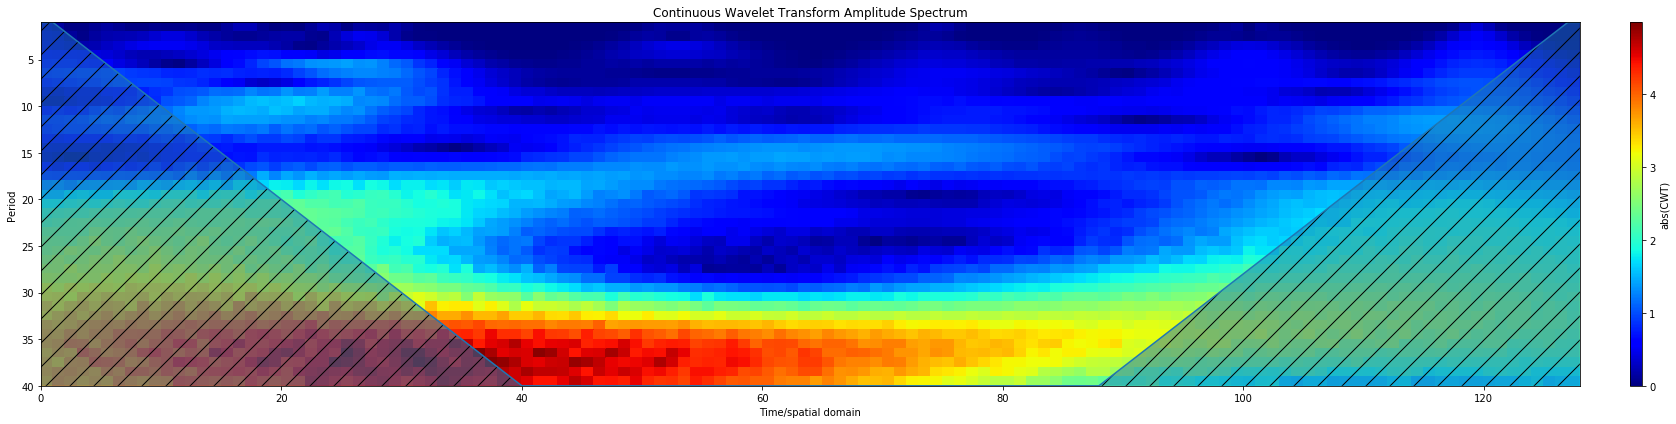

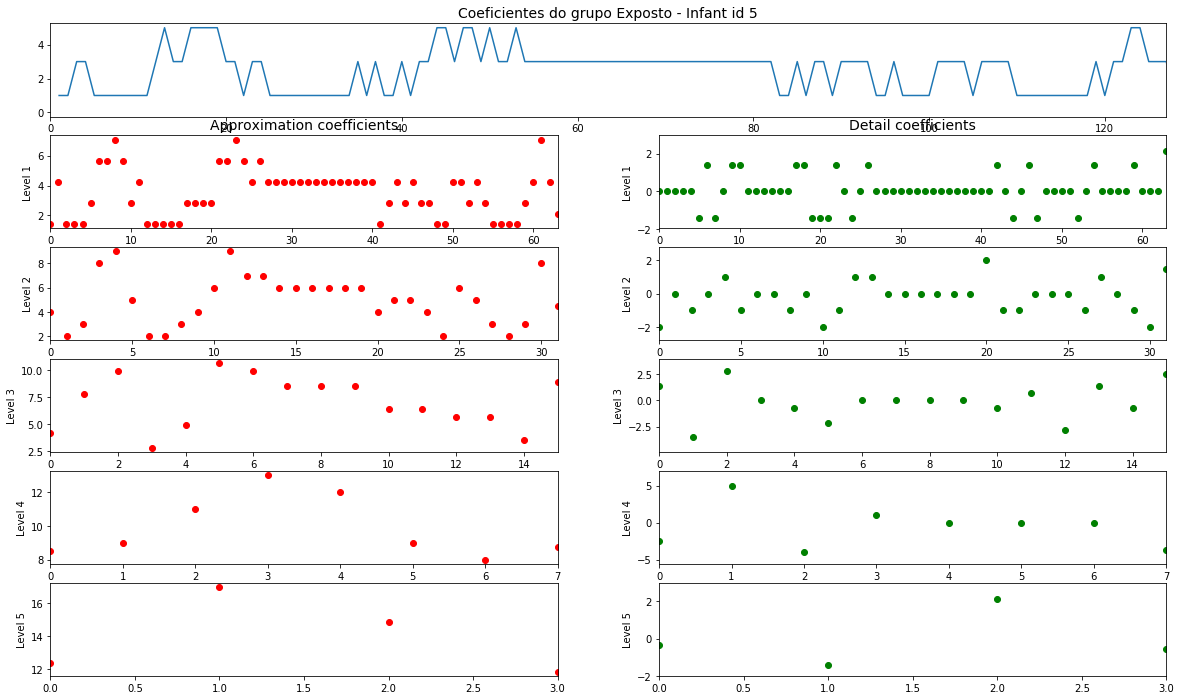

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


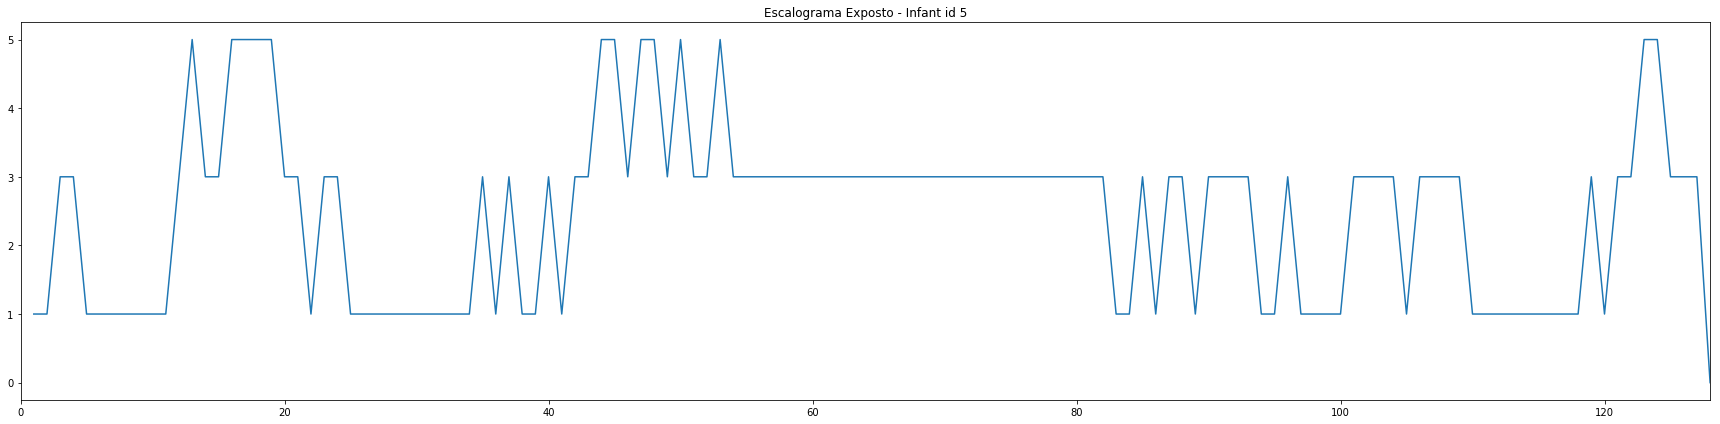

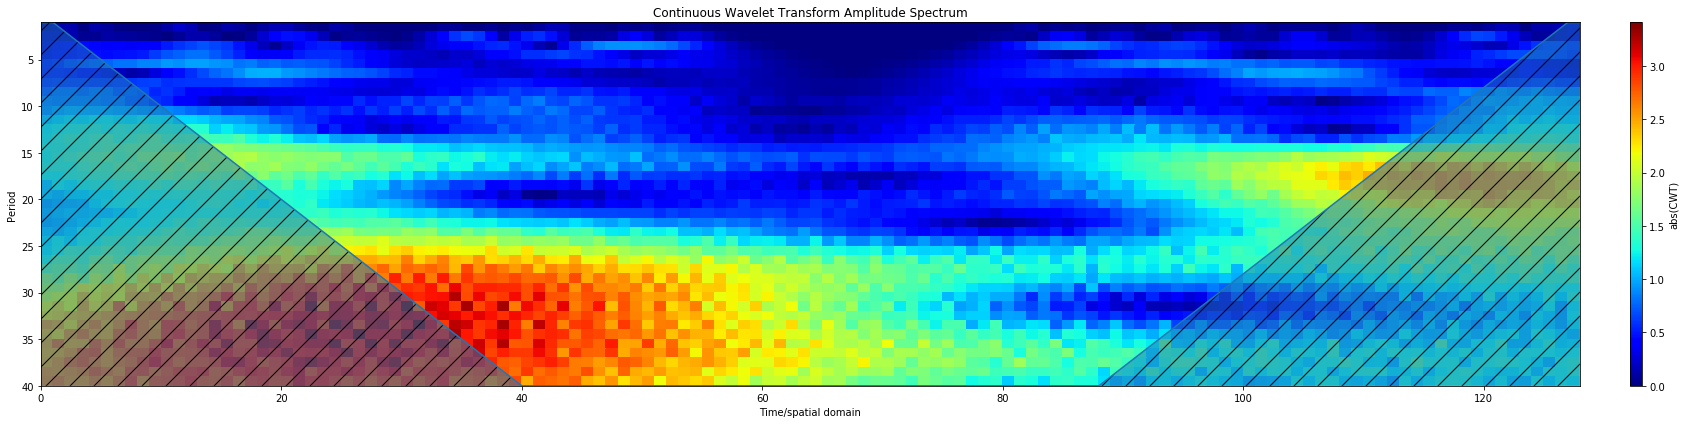

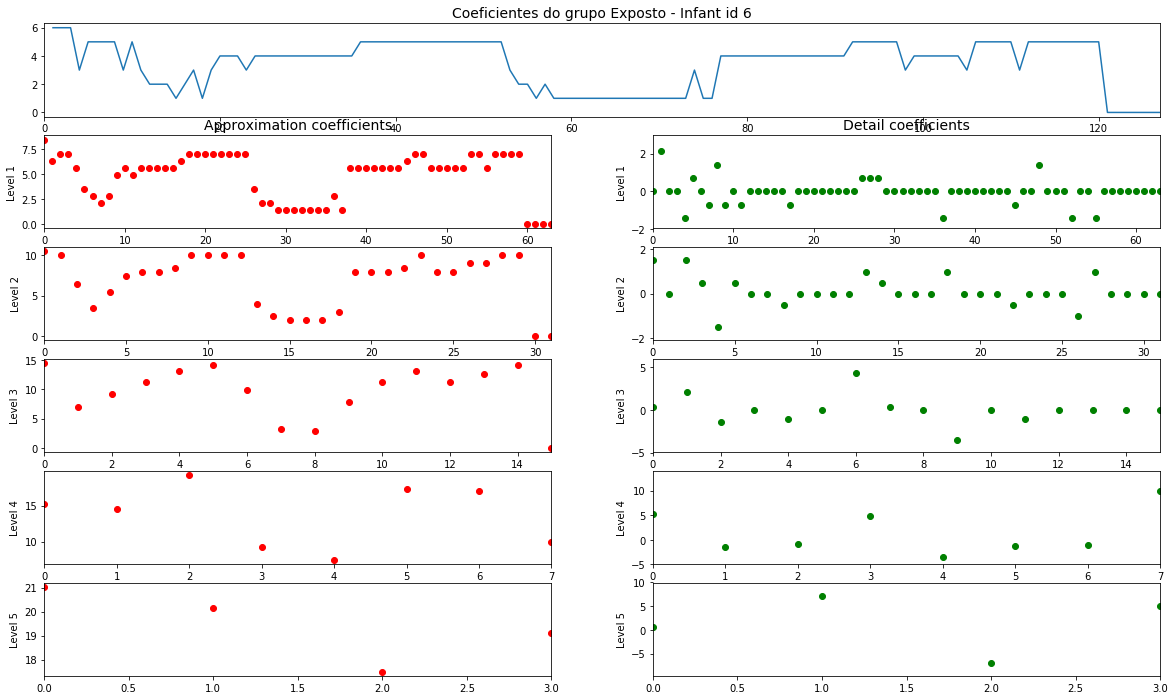

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


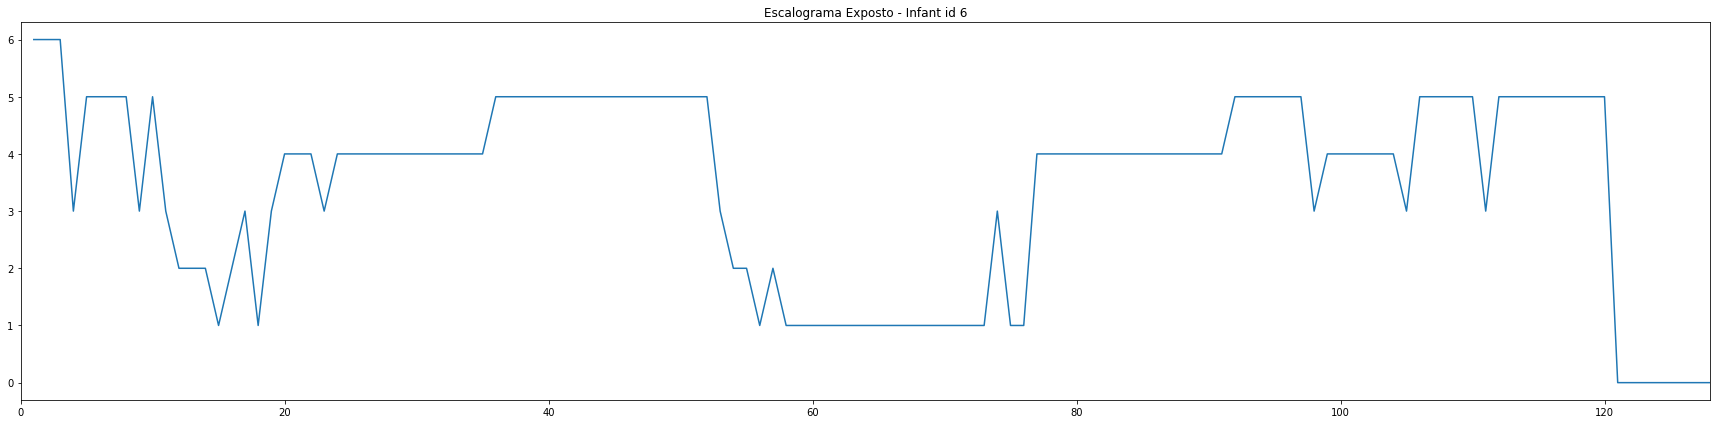

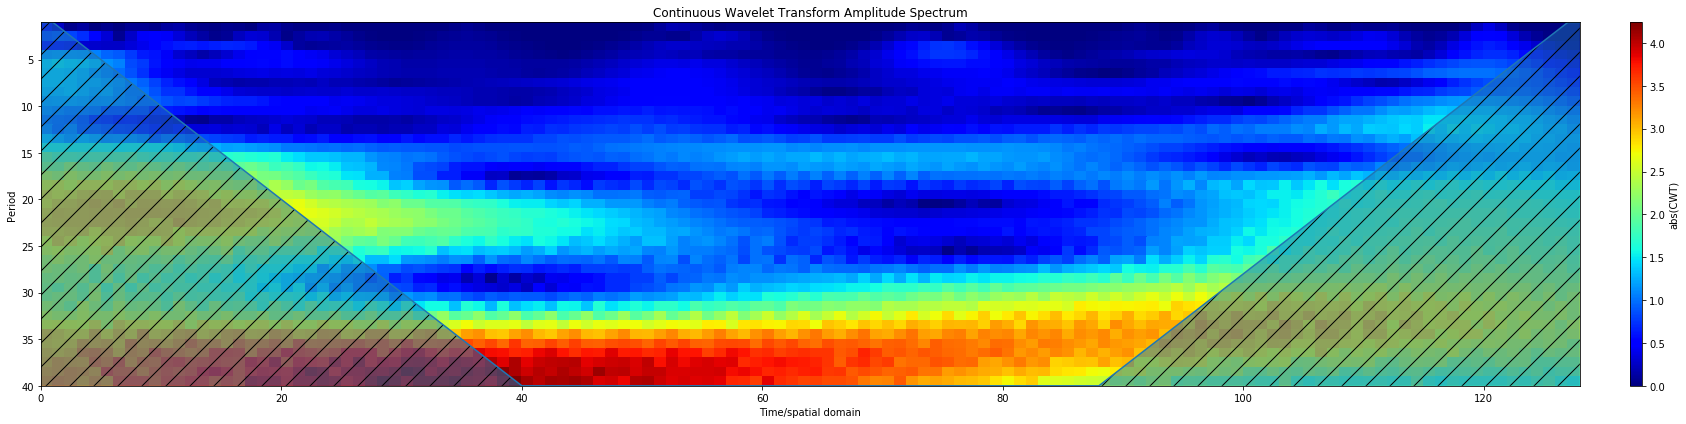

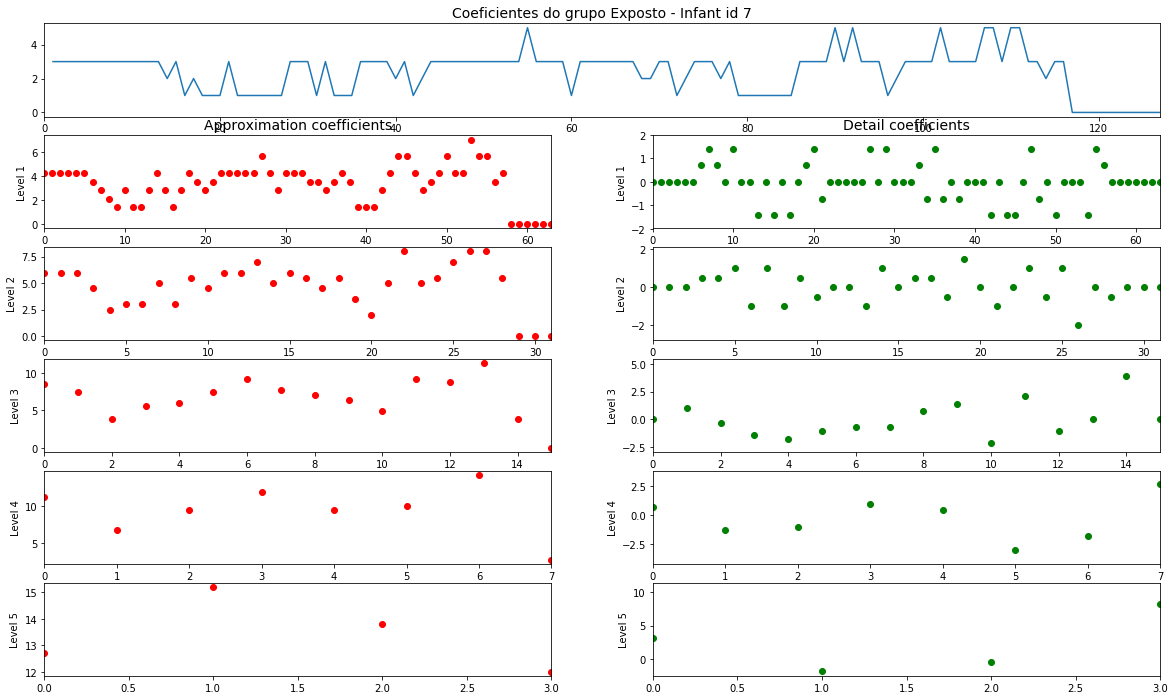

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


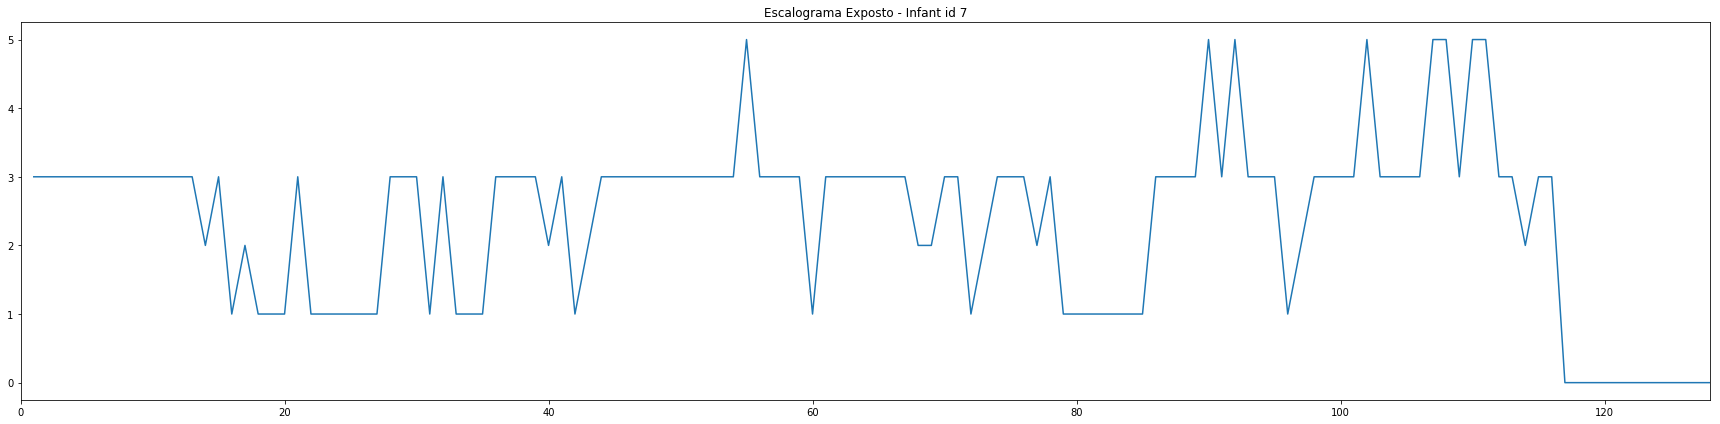

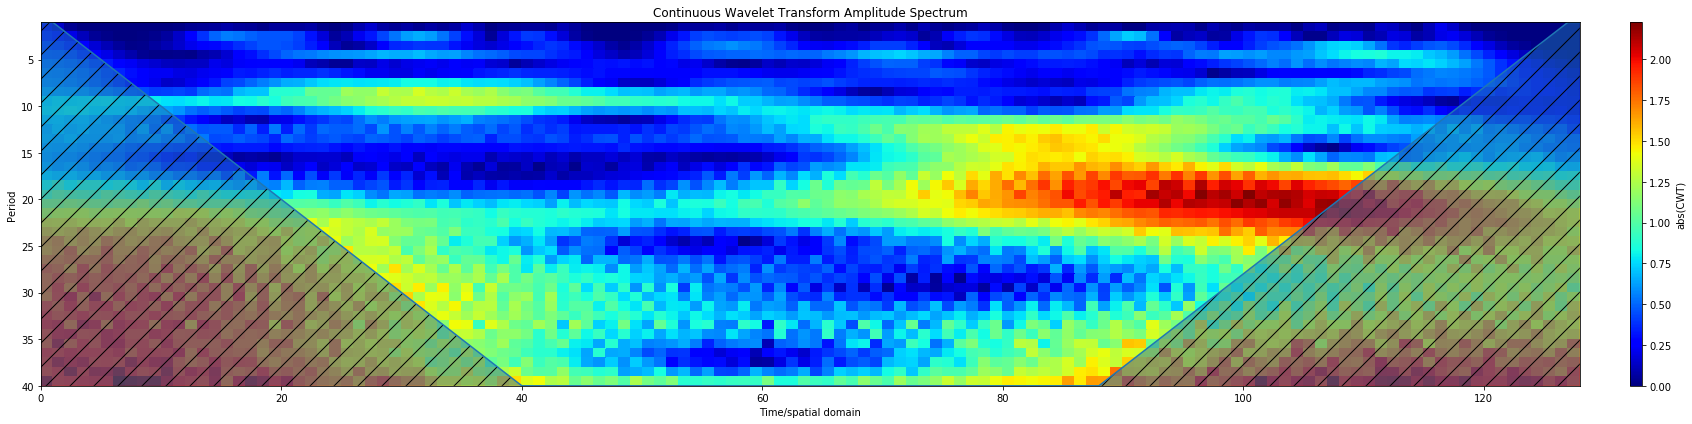

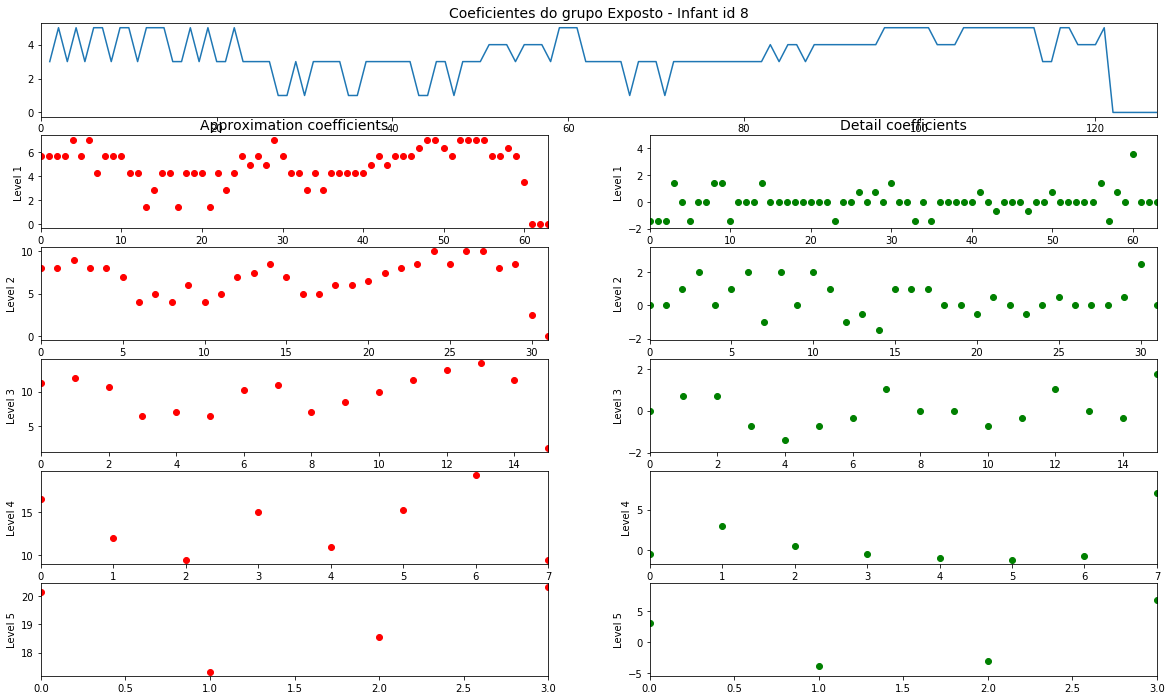

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


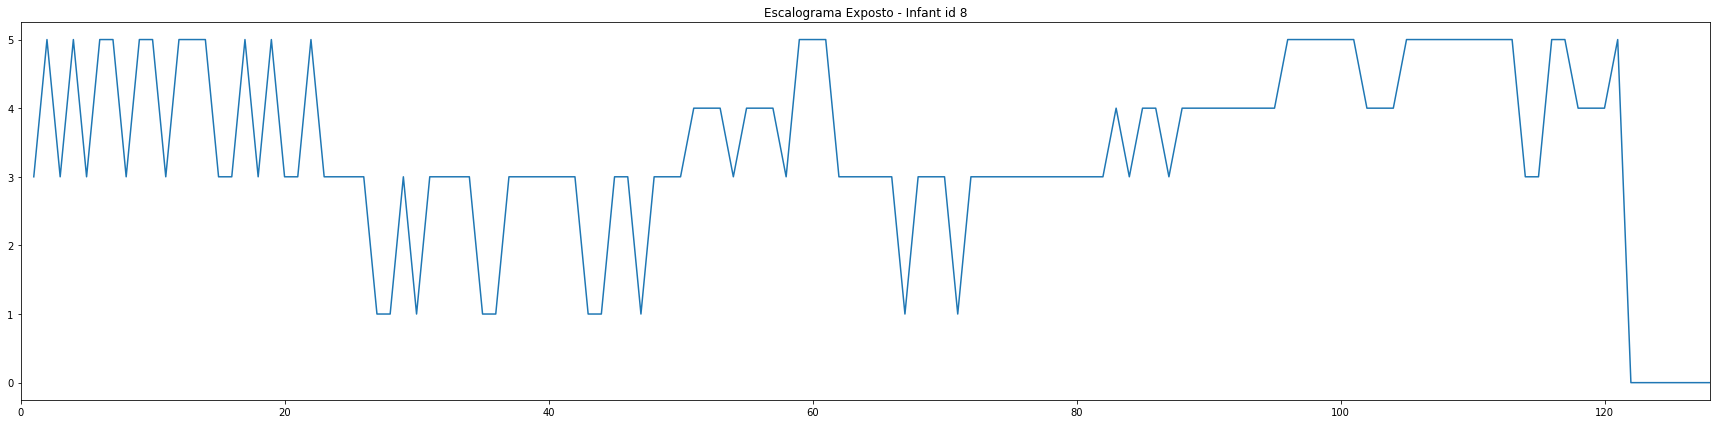

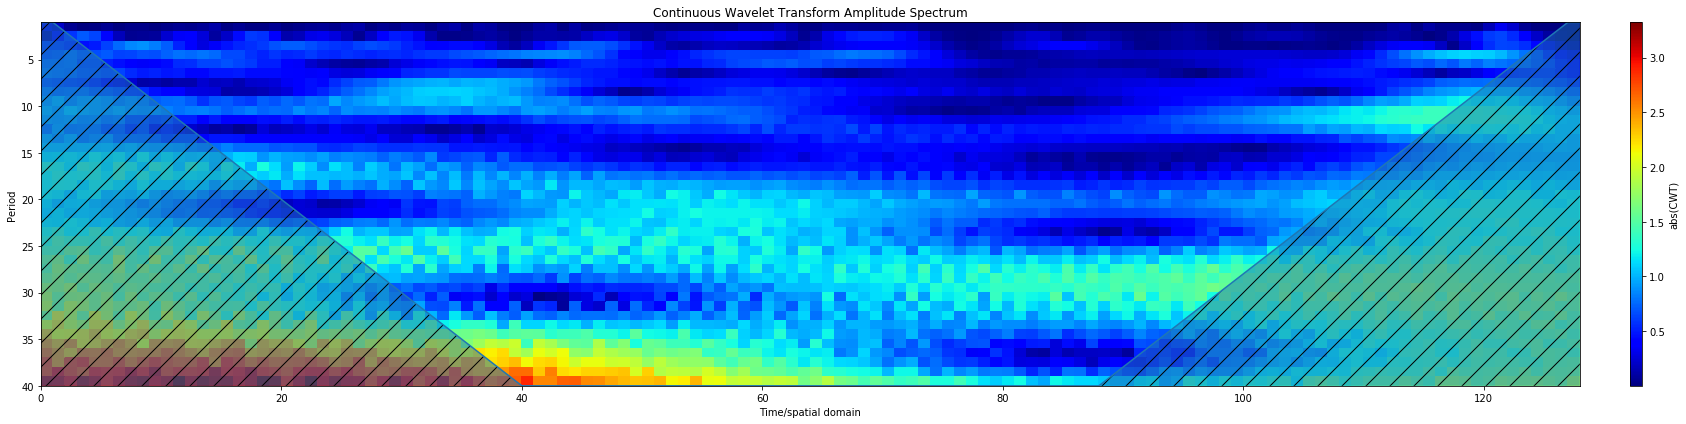

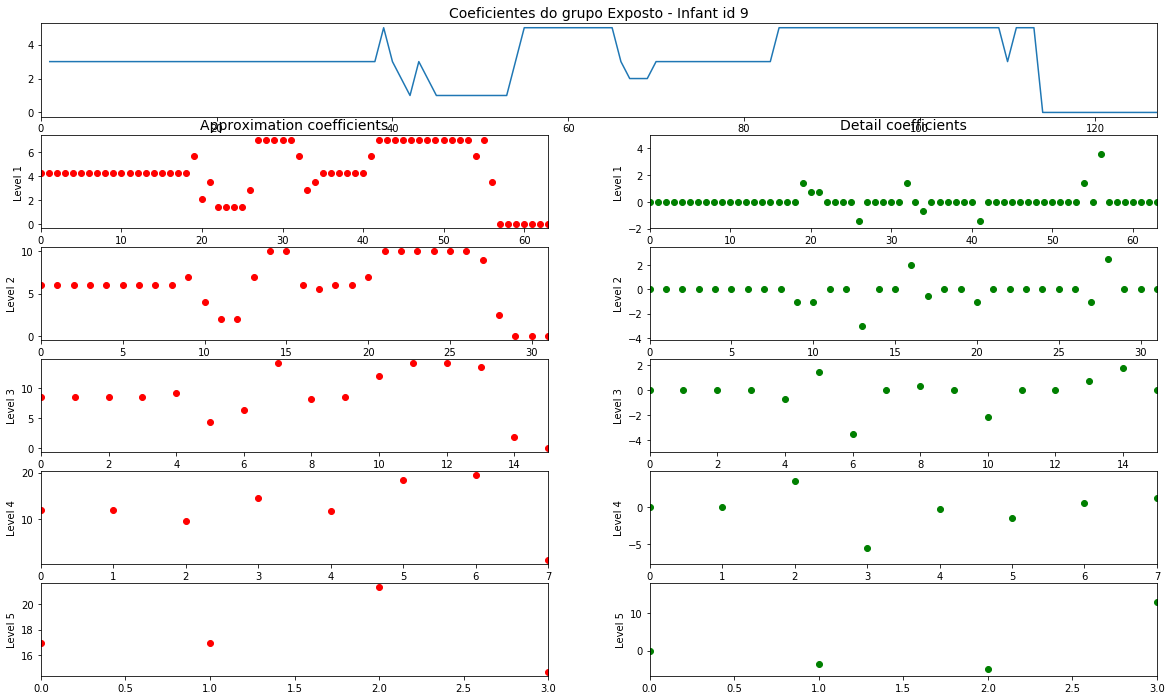

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


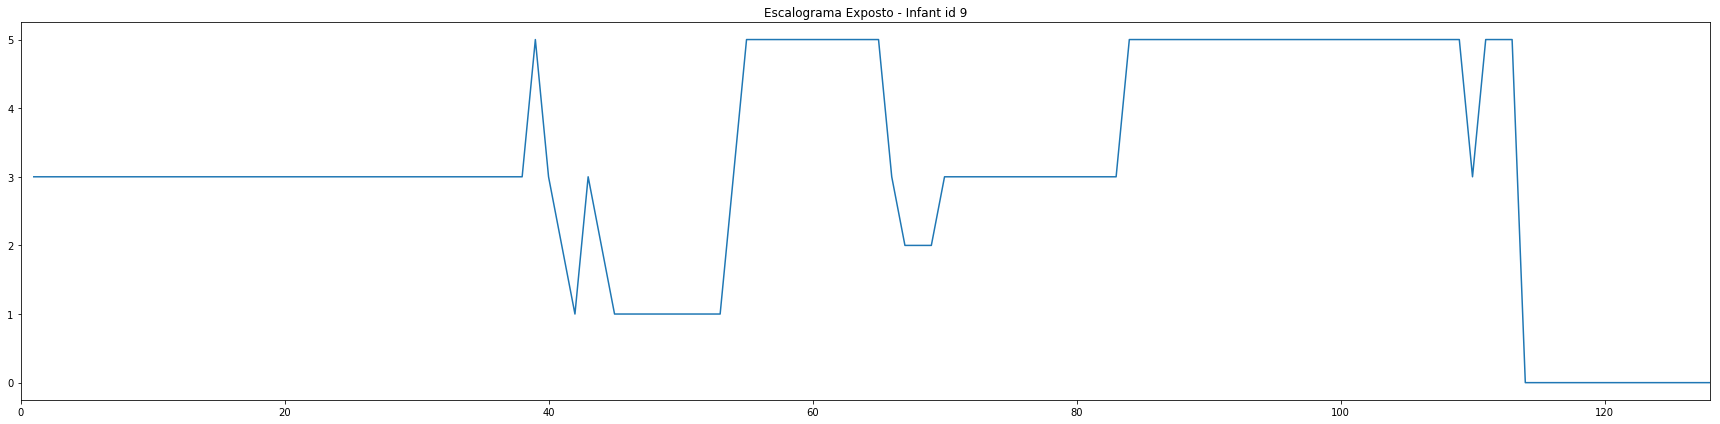

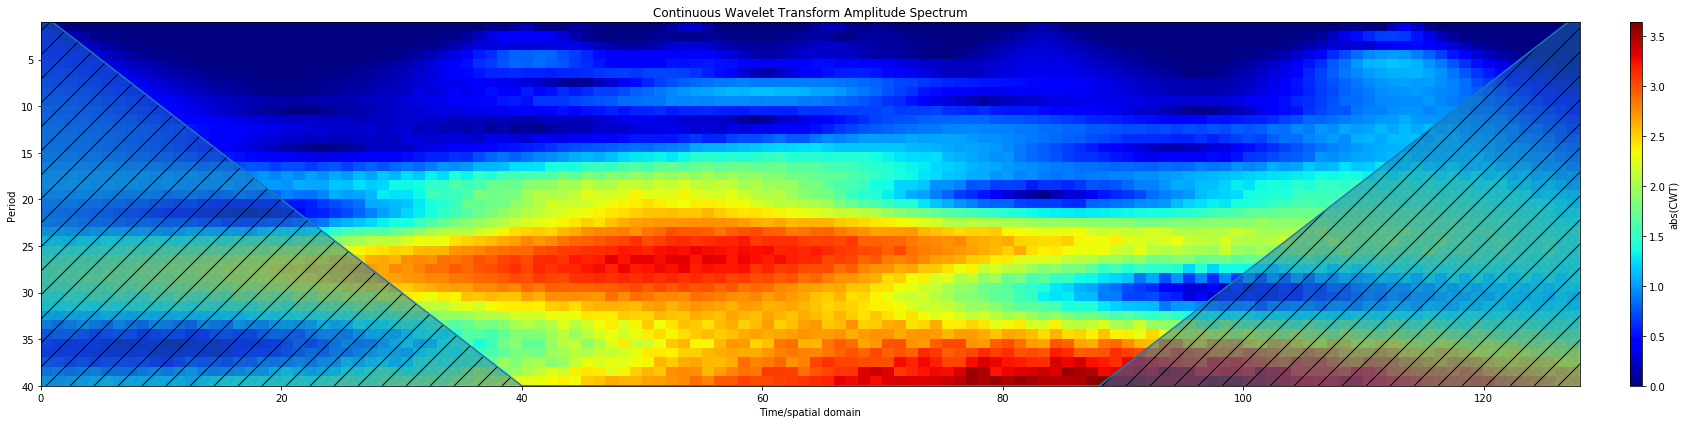

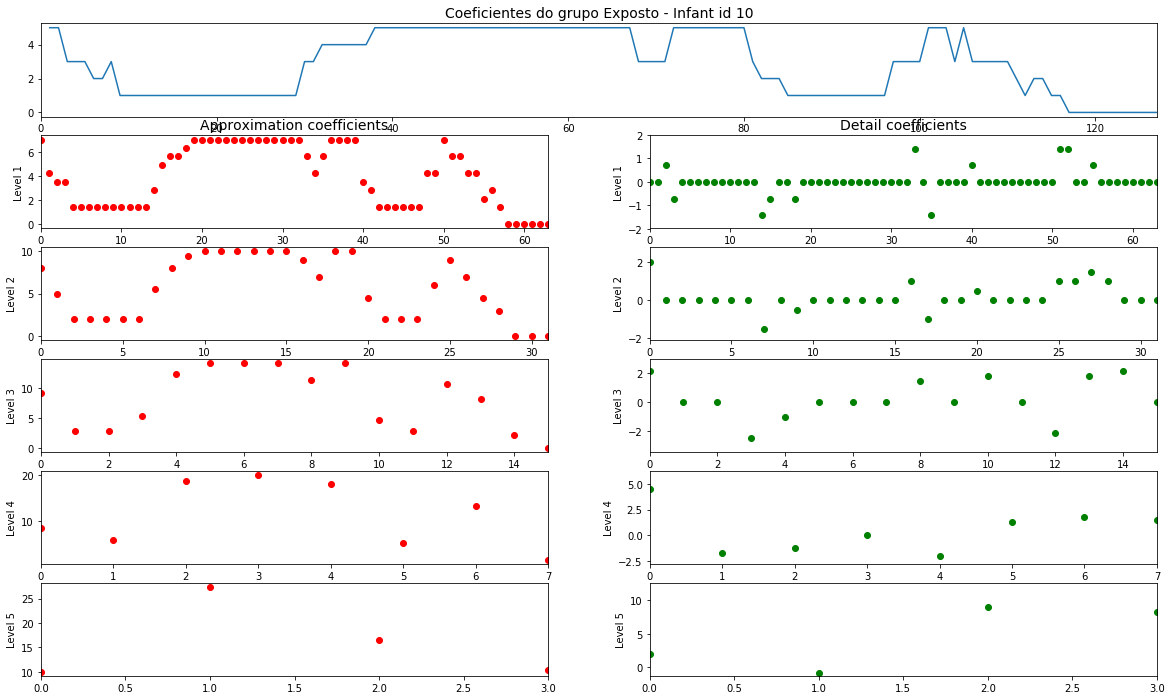

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


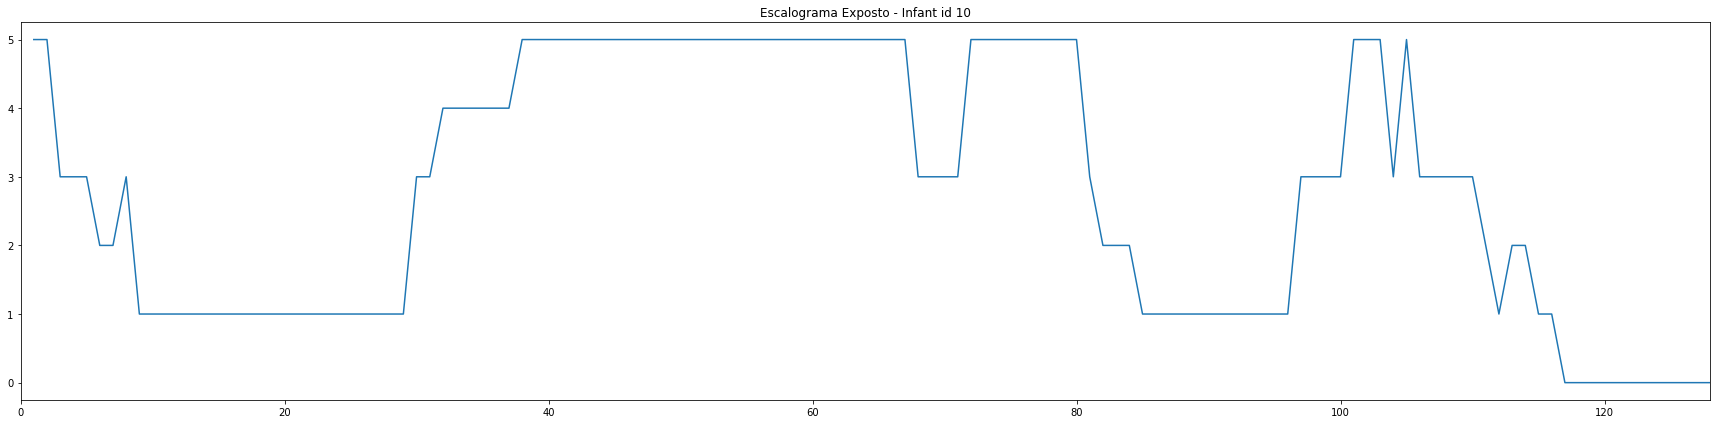

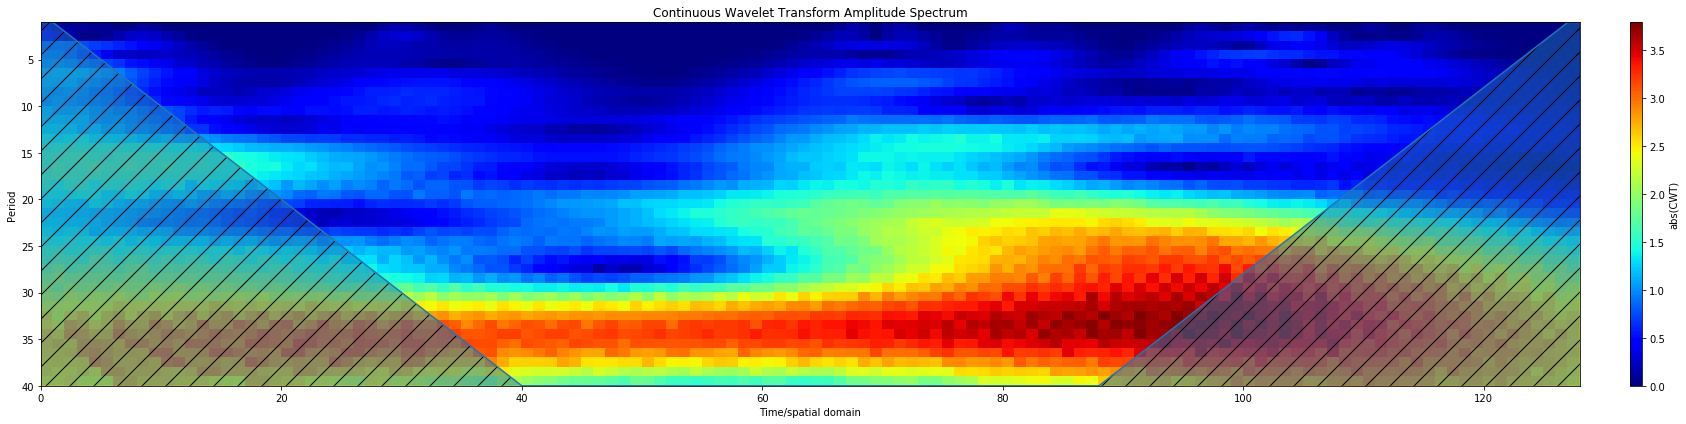

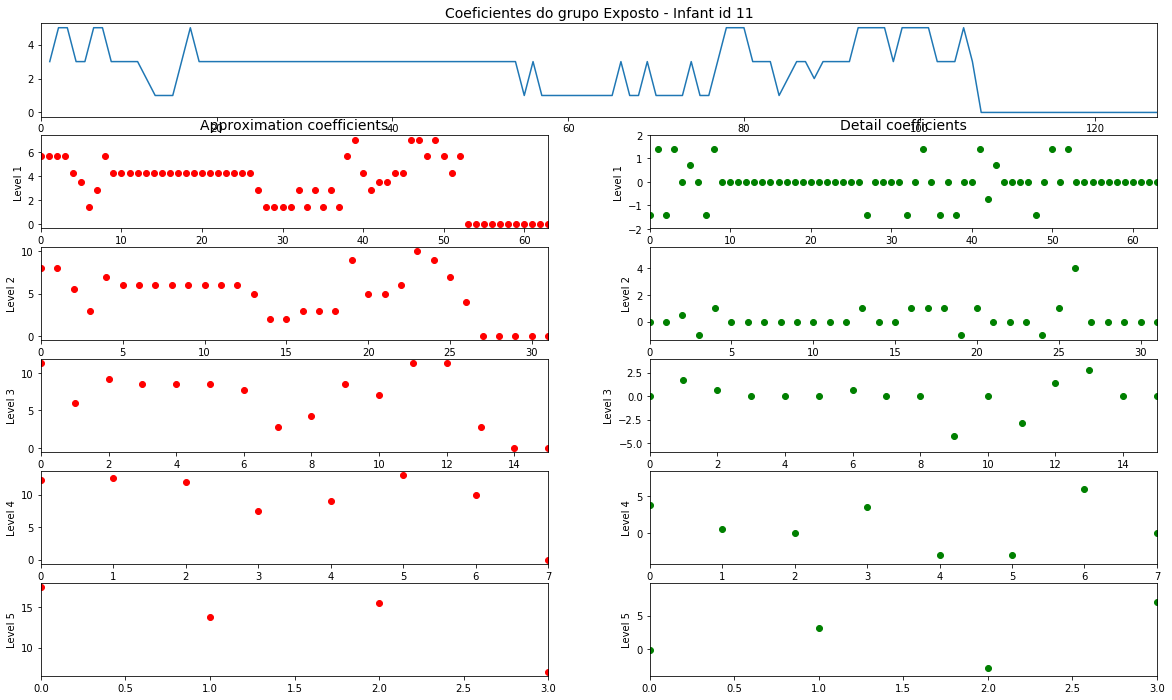

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


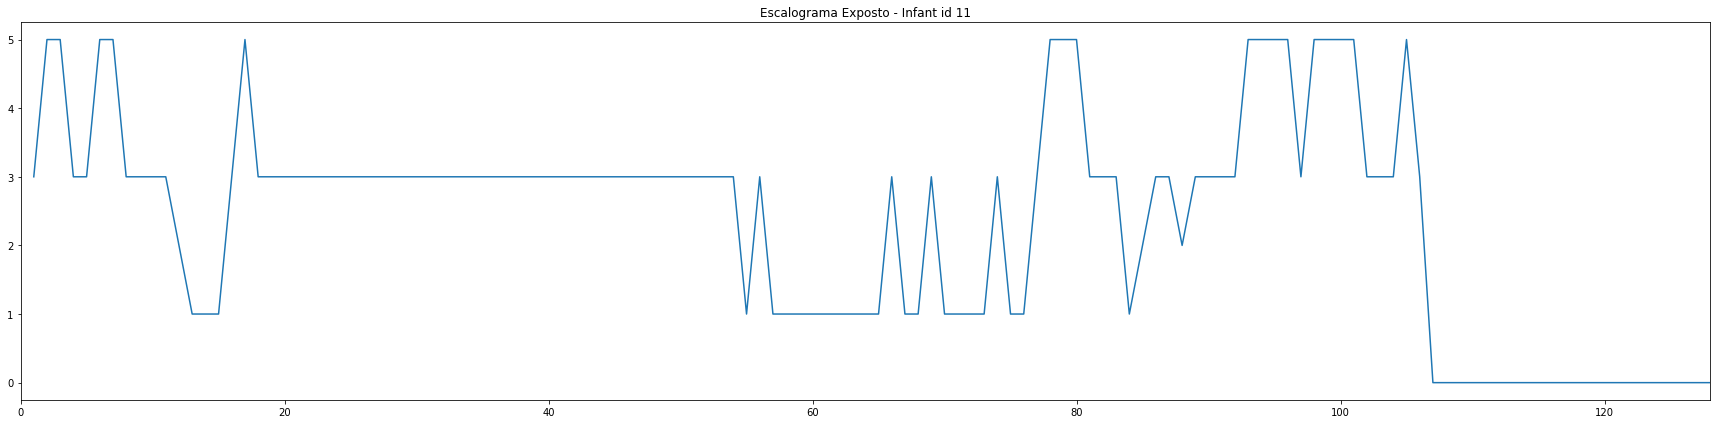

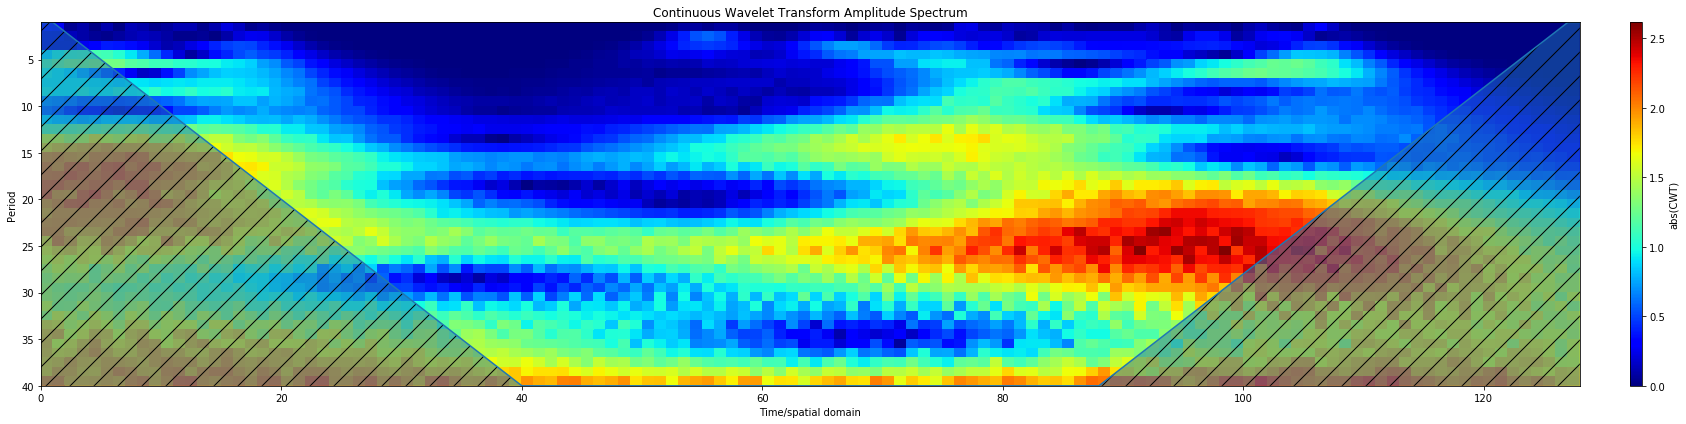

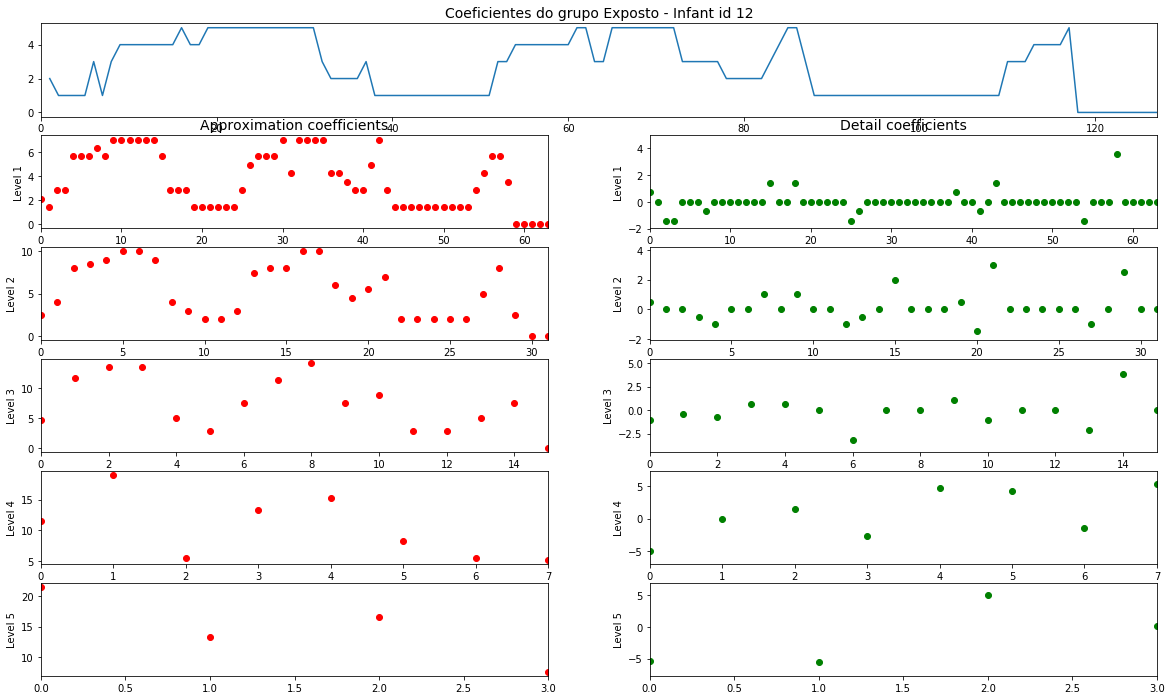

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


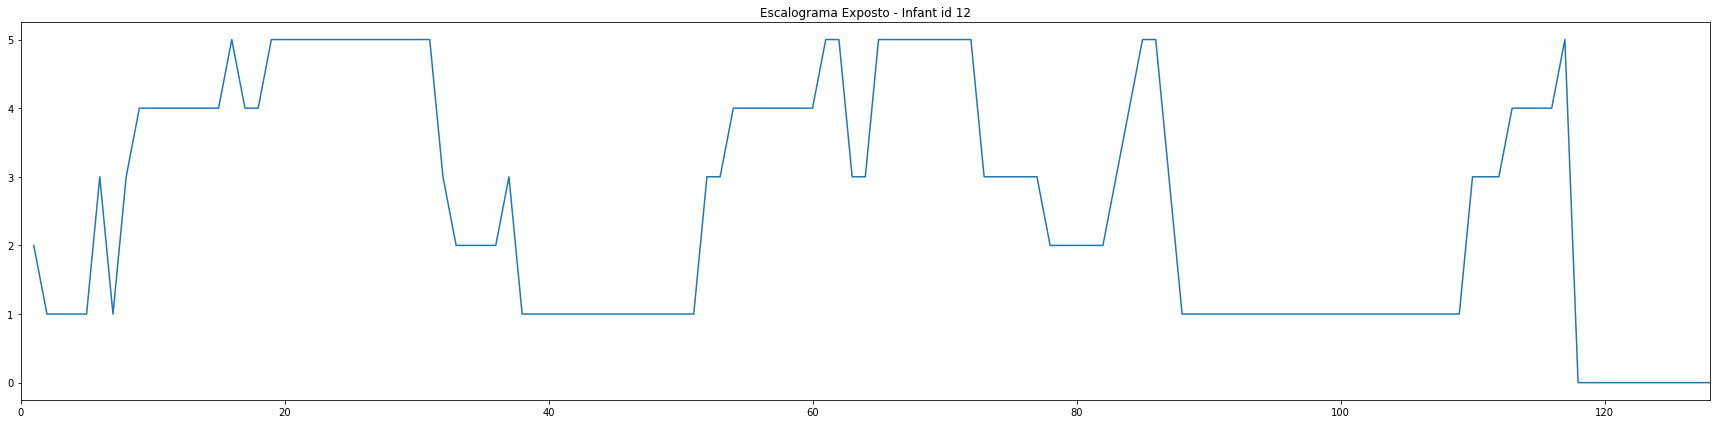

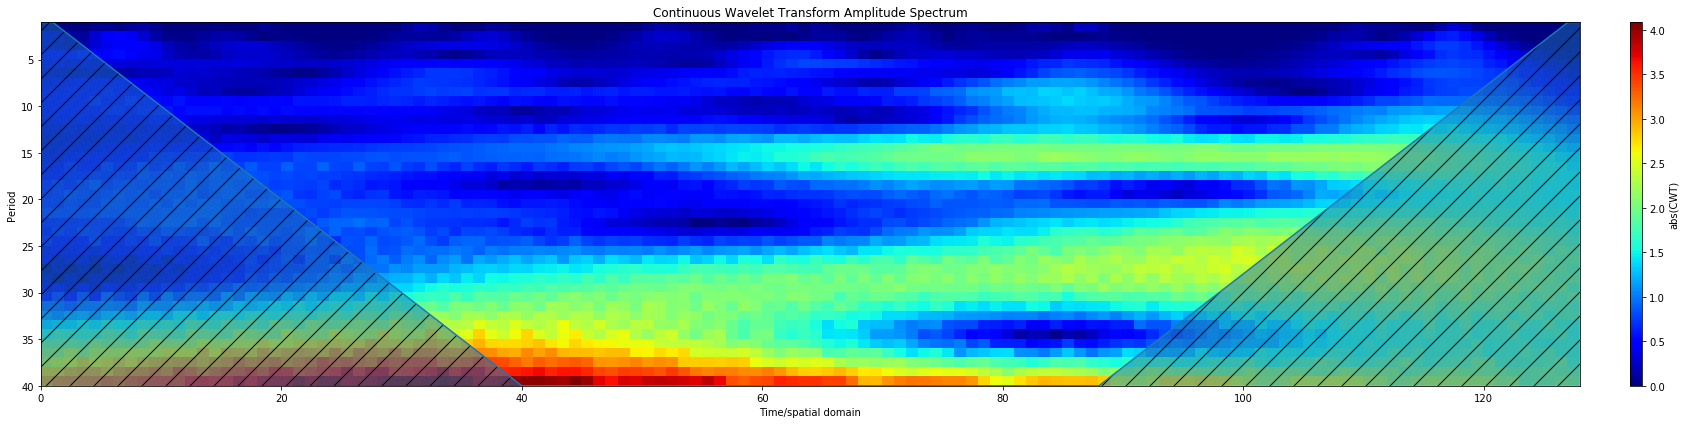

In [192]:
''' 
Exercício 7 
Lista 5
Professora: Chang
Aluno: Renan de Luca Avila
'''
w = 'haar'
data = getgrp1()

for i in range(1,13):
    signal = data[f'state {i}']
    plot_coeffs(signal, w, f'Coeficientes do grupo Não exposto - Infant id {i}', 5, True)
    plt.show()
    plot_scaleogram(signal, title=f'Escalograma Não exposto - Infant id {i}', figsize=(24,6))
    plt.show()

data = getgrp2()
for i in range(1,13):
    signal = data[f'state {i}']
    plot_coeffs(data[f'state {i}'], w, f'Coeficientes do grupo Exposto - Infant id {i}', 5, True)
    plt.show()
    plot_scaleogram(signal, title=f'Escalograma Exposto - Infant id {i}', figsize=(24,6))
    plt.show()

## Exercício 8
- Lista 5
- Professora: Chang
- Aluno: Renan de Luca Avila

maximum level is 5


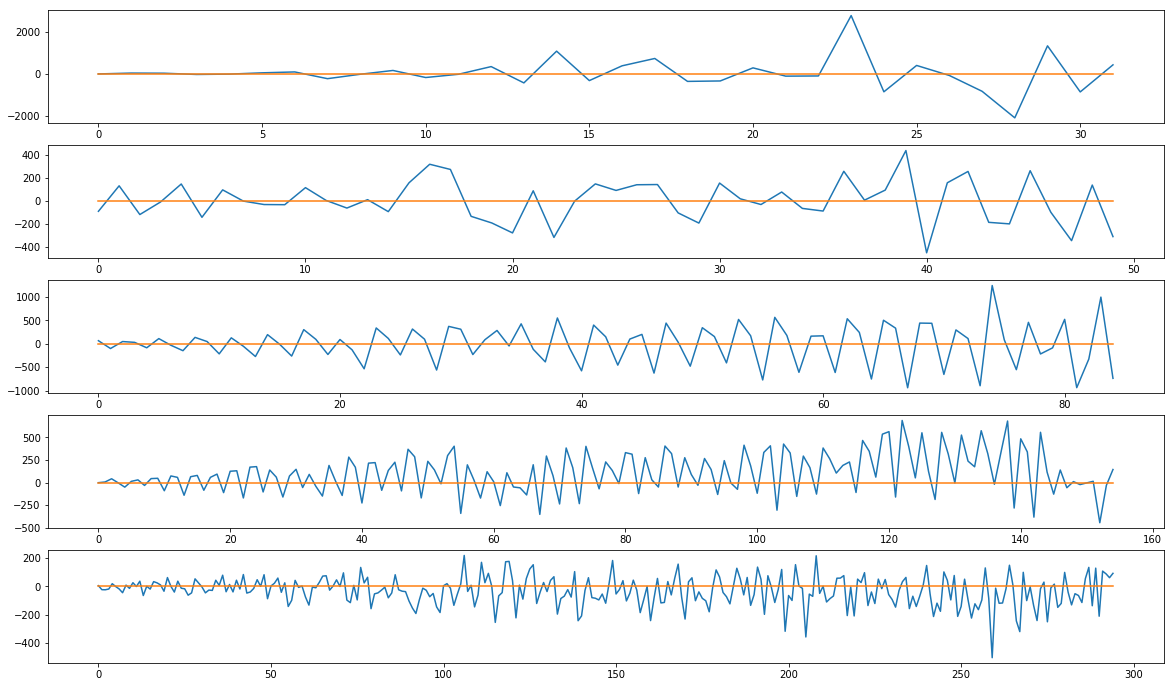

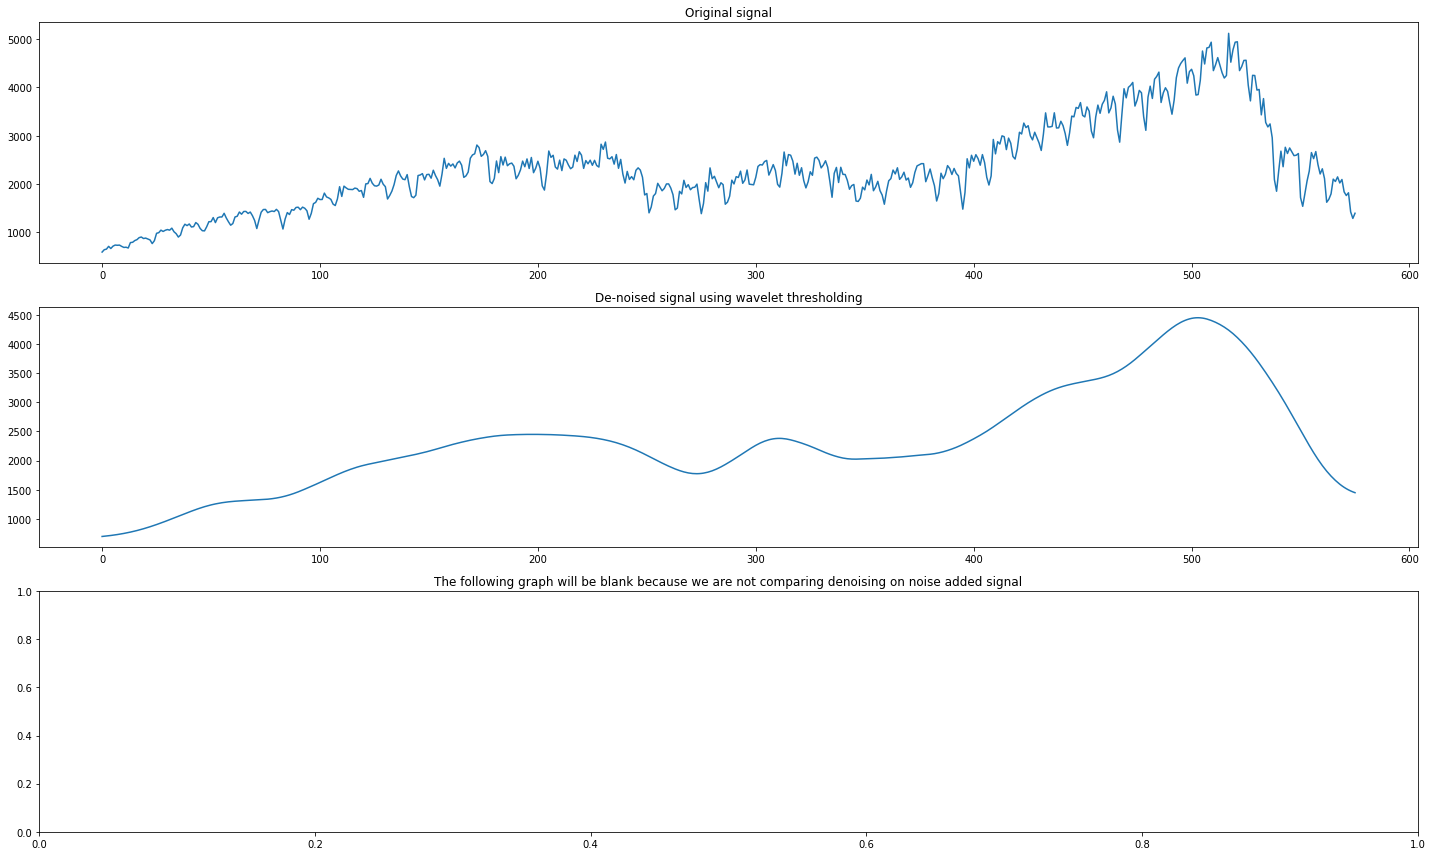

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


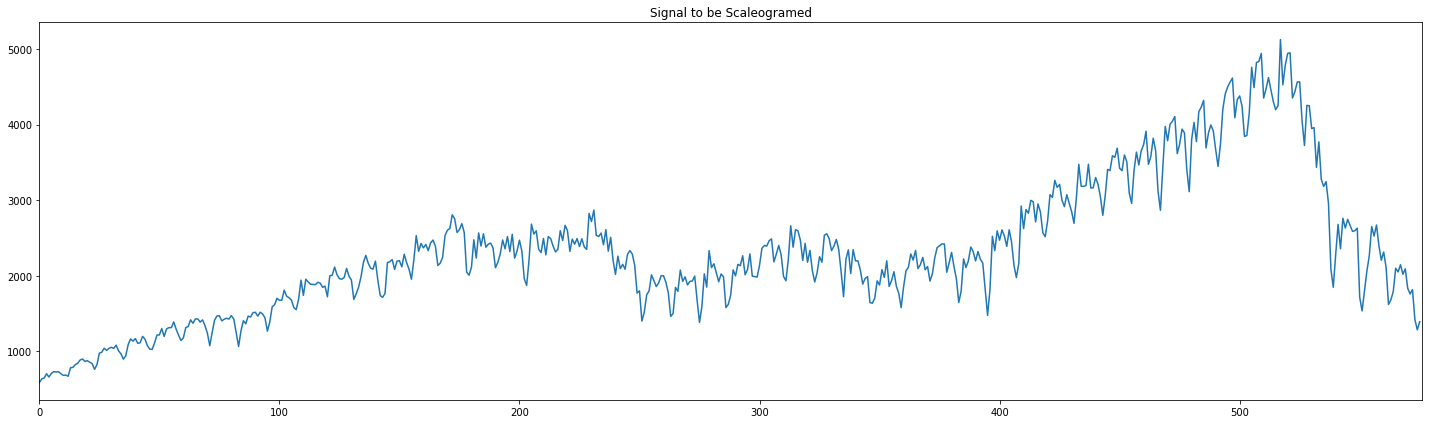

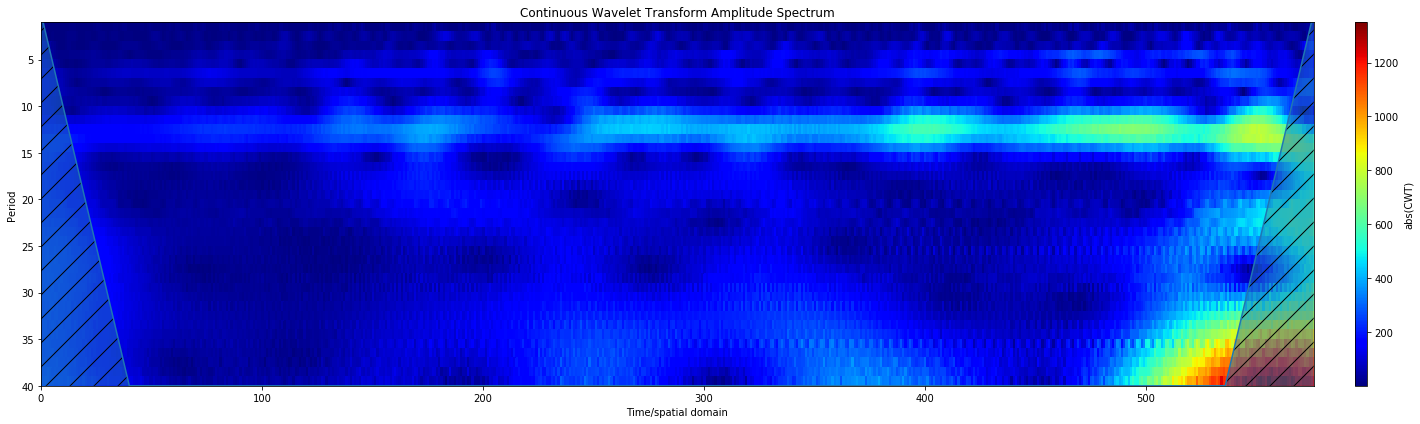

In [165]:
''' 
Exercício 8 
Lista 5
Professora: Chang
Aluno: Renan de Luca Avila
'''
cement = getcement()
signal_cement = cement['Cement']
wavelet_denoise(signal_cement, wav_name)

scg.set_default_wavelet('cmor1-1.5')

plot_scaleogram(signal_cement, figsize=(20,6))

## Exercício 3
- Lista 5
- Professora: Chang
- Aluno: Renan de Luca Avila

Obs.: Não consegui fazer esse...

In [193]:
''' 
Exercício 3
Lista 5
Professora: Chang
Aluno: Renan de Luca Avila
'''
# Não consegui

' \nExercício 3\nLista 5\nProfessora: Chang\nAluno: Renan de Luca Avila\n'